# Using Keras to train MixtureOfSVGPExperts on the Motorcycle Data Set

This notebook is a basic example of configuring and training a Mixture of Gaussian Process Experts (using `MixtureOfSVGPExperts`) on the motorcycle data set. It shows how to instantiate the model in the special two expert case when only a single gating function is needed (not two!) and the gating network can be calculated in closed form. It then shows how to save and load the model using Keras. Finally, it shows how to instantiate and train the model in the general case with more that two experts.

In [1]:
import numpy as np
import gpflow as gpf
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import clear_output
import yaml
import json
import time

from gpflow import default_float
from gpflow.models import SVGP
from gpflow.utilities import print_summary

from mogpe.keras.experts import SVGPExpert
# from mogpe.keras.gps import SVGPPrior
from mogpe.keras.gating_networks import SVGPGatingNetwork
from mogpe.keras.mixture_of_experts import MixtureOfSVGPExperts
from mogpe.keras.plotting.plotter import Plotter1D
from mogpe.keras.utils import model_from_yaml

Let's start by loading the motorcycle dataset and plotting it to see what we're dealing with.

In [2]:
def load_mcycle_dataset(filename='../data/mcycle.csv'):
    df = pd.read_csv(filename, sep=',')
    X = pd.to_numeric(df['times']).to_numpy().reshape(-1, 1)
    Y = pd.to_numeric(df['accel']).to_numpy().reshape(-1, 1)

    X = tf.convert_to_tensor(X, dtype=default_float())
    Y = tf.convert_to_tensor(Y, dtype=default_float())
    print("Input data shape: ", X.shape)
    print("Output data shape: ", Y.shape)

    # standardise input
    mean_x, var_x = tf.nn.moments(X, axes=[0])
    mean_y, var_y = tf.nn.moments(Y, axes=[0])
    X = (X - mean_x) / tf.sqrt(var_x)
    Y = (Y - mean_y) / tf.sqrt(var_y)
    data = (X, Y)
    return data

Input data shape:  (133, 1)
Output data shape:  (133, 1)


2022-02-15 10:35:02.693058: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


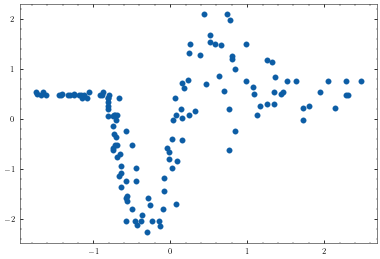

In [3]:
data_file = '../data/mcycle.csv'
dataset = load_mcycle_dataset(filename=data_file)
X, Y = dataset
num_data, input_dim = X.shape
output_dim = Y.shape[1]
plt.scatter(X, Y)

Given this data set, let's specify some of the model and training parameters. It is clear that there is a low noise, long lengthscales function at $x<-1$ and at $x>-1$ the noise increases and the lengthscale shortens. With this knowledge, let's initialise expert one with a short lengthscale and expert two with a longer lengthscale. We specify each expert to have 6 inducing points and the gating network to have 7 inducing points.

In [4]:
num_experts = 2
# experts_lengthscales = [1.0, 1.0]  # lengthsales for expert 1 and 2
experts_lengthscales = [1.0, 10.0]  # lengthsales for expert 1 and 2
num_inducing_expert = 6  # number of inducing points for each expert
num_inducing_gating = 7  # number of inducing points for gating network

In order to initialie the `MixtureOfSVGPExperts` class we must pass it a list of `SVGPExpert` instances and an instance of `SVGPGatingNetwork`. Let's start by creating the list of experts. To do this we create a `Likelihood` and `SVGPPrior` for each expert.

In [5]:
def sample_inducing_inputs_from_data(X, num_inducing):
    idx = np.random.choice(range(X.shape[0]), size=num_inducing, replace=False) 
    return X.numpy()[idx, ...].reshape(-1, input_dim)

def sample_inducing_variable_from_data(X, num_inducing):
    inducing_inputs = sample_inducing_inputs_from_data(X, num_inducing)
    return gpf.inducing_variables.InducingPoints(inducing_inputs)

def init_expert(lengthscales=1.0, kernel_variance=1.0, noise_variance=1.0):
    inducing_variable = sample_inducing_variable_from_data(X, num_inducing_expert)
    mean_function = gpf.mean_functions.Constant()
    likelihood = gpf.likelihoods.Gaussian(noise_variance)
    kernel = gpf.kernels.RBF(lengthscales=lengthscales, variance=kernel_variance)
#     svgp = SVGPPrior(kernel, mean_function=mean_function, inducing_variable=inducing_variable)
#     return SVGPExpert(svgp=svgp, likelihood=likelihood)
#     svgp = SVGP(kernel, likelihood=likelihood, mean_function=mean_function, inducing_variable=inducing_variable)
    return SVGPExpert(kernel, likelihood=likelihood, inducing_variable=inducing_variable, mean_function=mean_function)
#     return SVGPExpert(svgp=svgp)

In [6]:
experts_list = [init_expert(lengthscales=experts_lengthscales[k]) for k in range(num_experts)]
for expert in experts_list:
    print(expert.gp.kernel.lengthscales)
    print(expert.gp.kernel.variance)
# for var in expert.trainable_variables:
#     var._trainable=False
#     print(var)
print_summary(expert, fmt="notebook")
print_summary(expert.trainable_parameters, fmt="notebook")
print_summary(expert.trainable_variables, fmt="notebook")

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=1.0>
<Parameter: dtype=float64, shape=[], fn="softplus", numpy=1.0>
<Parameter: dtype=float64, shape=[], fn="softplus", numpy=10.0>
<Parameter: dtype=float64, shape=[], fn="softplus", numpy=1.0>


name,class,transform,prior,trainable,shape,dtype,value
SVGPExpert._self_tracked_trackables[0]._trainable_weights[0] SVGPExpert._gp._trainable_weights[0],ResourceVariable,,,True,"(6, 1)",float64,[[0....
SVGPExpert._self_tracked_trackables[0]._trainable_weights[1] SVGPExpert._gp._trainable_weights[1],ResourceVariable,,,True,"(1, 21)",float64,"[[1., 0., 0...."
SVGPExpert._self_tracked_trackables[0]._self_tracked_trackables[0]._trainable_weights[0] SVGPExpert._self_tracked_trackables[0].mean_function._trainable_weights[0] SVGPExpert._gp._self_tracked_trackables[0]._trainable_weights[0] SVGPExpert._gp.mean_function._trainable_weights[0],ResourceVariable,,,True,"(1,)",float64,[0.]
SVGPExpert._self_tracked_trackables[0]._self_tracked_trackables[0]._self_tracked_trackables[0] SVGPExpert._self_tracked_trackables[0]._self_tracked_trackables[0].c SVGPExpert._self_tracked_trackables[0].mean_function._self_tracked_trackables[0] SVGPExpert._self_tracked_trackables[0].mean_function.c SVGPExpert._gp._self_tracked_trackables[0]._self_tracked_trackables[0] SVGPExpert._gp._self_tracked_trackables[0].c SVGPExpert._gp.mean_function._self_tracked_trackables[0] SVGPExpert._gp.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.]
SVGPExpert._self_tracked_trackables[0]._self_tracked_trackables[1]._trainable_weights[0] SVGPExpert._self_tracked_trackables[0].kernel._trainable_weights[0] SVGPExpert._gp._self_tracked_trackables[1]._trainable_weights[0] SVGPExpert._gp.kernel._trainable_weights[0],ResourceVariable,,,True,(),float64,0.5413248546129181
SVGPExpert._self_tracked_trackables[0]._self_tracked_trackables[1]._trainable_weights[1] SVGPExpert._self_tracked_trackables[0].kernel._trainable_weights[1] SVGPExpert._gp._self_tracked_trackables[1]._trainable_weights[1] SVGPExpert._gp.kernel._trainable_weights[1],ResourceVariable,,,True,(),float64,9.99995459903963
SVGPExpert._self_tracked_trackables[0]._self_tracked_trackables[1]._self_tracked_trackables[0] SVGPExpert._self_tracked_trackables[0]._self_tracked_trackables[1].variance SVGPExpert._self_tracked_trackables[0].kernel._self_tracked_trackables[0] SVGPExpert._self_tracked_trackables[0].kernel.variance SVGPExpert._gp._self_tracked_trackables[1]._self_tracked_trackables[0] SVGPExpert._gp._self_tracked_trackables[1].variance SVGPExpert._gp.kernel._self_tracked_trackables[0] SVGPExpert._gp.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SVGPExpert._self_tracked_trackables[0]._self_tracked_trackables[1]._self_tracked_trackables[1] SVGPExpert._self_tracked_trackables[0]._self_tracked_trackables[1].lengthscales SVGPExpert._self_tracked_trackables[0].kernel._self_tracked_trackables[1] SVGPExpert._self_tracked_trackables[0].kernel.lengthscales SVGPExpert._gp._self_tracked_trackables[1]._self_tracked_trackables[1] SVGPExpert._gp._self_tracked_trackables[1].lengthscales SVGPExpert._gp.kernel._self_tracked_trackables[1] SVGPExpert._gp.kernel.lengthscales,Parameter,Softplus,,True,(),float64,10.0
SVGPExpert._self_tracked_trackables[0]._self_tracked_trackables[2]._trainable_weights[0] SVGPExpert._self_tracked_trackables[0].likelihood._trainable_weights[0] SVGPExpert._gp._self_tracked_trackables[2]._trainable_weights[0] SVGPExpert._gp.likelihood._trainable_weights[0],ResourceVariable,,,True,(),float64,0.5413232726357509
SVGPExpert._self_tracked_trackables[0]._self_tracked_trackables[2]._self_tracked_trackables[0] SVGPExpert._self_tracked_trackables[0]._self_tracked_trackables[2].variance SVGPExpert._self_tracked_trackables[0].likelihood._self_tracked_trackables[0] SVGPExpert._self_tracked_trackables[0].likelihood.variance SVGPExpert._gp._self_tracked_trackables[2]._self_tracked_trackables[0] SVGPExpert._gp._self_tracked_trackables[2].variance SVGPExpert._gp.likelihood._self_tracked_trackables[0] SVGPExpert._gp.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


2022-02-15 10:35:03.267070: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


name,class,transform,prior,trainable,shape,dtype,value
tuple[0],Parameter,Identity,,True,"(6, 1)",float64,[[0....
tuple[1],Parameter,FillTriangular,,True,"(1, 6, 6)",float64,"[[[1., 0., 0...."
tuple[2],Parameter,Identity,,True,"(1,)",float64,[0.]
tuple[3],Parameter,Softplus,,True,(),float64,1.0
tuple[4],Parameter,Softplus,,True,(),float64,10.0
tuple[5],Parameter,Softplus + Shift,,True,(),float64,1.0
tuple[6],Parameter,Identity,,True,"(6, 1)",float64,[[-1.08380188...


name,class,transform,prior,trainable,shape,dtype,value
list[0],ResourceVariable,,,True,"(6, 1)",float64,[[0....
list[1],ResourceVariable,,,True,"(1, 21)",float64,"[[1., 0., 0...."
list[2],ResourceVariable,,,True,"(1,)",float64,[0.]
list[3],ResourceVariable,,,True,(),float64,0.5413248546129181
list[4],ResourceVariable,,,True,(),float64,9.99995459903963
list[5],ResourceVariable,,,True,(),float64,0.5413232726357509
list[6],ResourceVariable,,,True,"(6, 1)",float64,[[-1.08380188...


Lovely stuff. We now need to create an instance of `SVGPGatingNetwork`. Remember that we only need a single gating function for the two expert case. Let's go ahead and create a single gating function and use it to construct our gating network. The `SVGPGatingNetwork` constructor accepts a `SVGPPrior` instance and uses it to select the right likelihood. It selects the `Bernoulli` likelihood if the `SVGPPrior` has a single output and selects the `Softmax` likelihood in the general case when a multioutput `SVGPPrior` (where each output dimension corresponds to a gating function).

In [7]:
def init_gating_network(num_gating_gps=1):
    if num_gating_gps == 1:
        inducing_variable = sample_inducing_variable_from_data(X, num_inducing_gating)
        kernel = gpf.kernels.RBF()
    else:
        kernel = gpf.kernels.SeparateIndependent([gpf.kernels.RBF() for _ in range(num_gating_gps)])
        inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(sample_inducing_variable_from_data(X, num_inducing_gating))
#     svgp = SVGPPrior(kernel, mean_function=gpf.mean_functions.Zero(), inducing_variable=inducing_variable, num_latent_gps=num_gating_gps)
    return SVGPGatingNetwork(kernel=kernel, mean_function=gpf.mean_functions.Zero(), inducing_variable=inducing_variable)
#     return SVGPGatingNetwork(svgp=svgp)

In [8]:
gating_network = init_gating_network()
# print_summary(gating_network, fmt="notebook")

We now have all the components to construct our `MixtureOfSVGPExperts` model so let's go ahead and do it.

In [9]:
model = MixtureOfSVGPExperts(experts_list=experts_list, 
                             gating_network=gating_network, 
                             num_data=X.shape[0], 
                             num_samples=1,
                             bound="further_gating")
# print_summary(model, fmt="notebook")

We can use the Plotter1D class from `mogpe.helpers.plotter` to plot our model before training.  
- The top plot shows mixing probablility for each expert,
- Middle plots show each experts latent GP,
- The bottom plot shows the models posterior with the mean (black line) and samples (green dots).

tfp.distributions.Categorical("gp_gating_network_ExpertIndicatorCategorical", batch_shape=[100], event_shape=[], dtype=int32)
(100, 2)
<class 'tensorflow_probability.python.distributions.categorical.Categorical'>


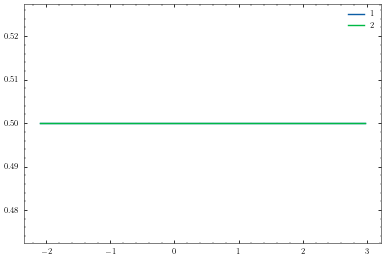

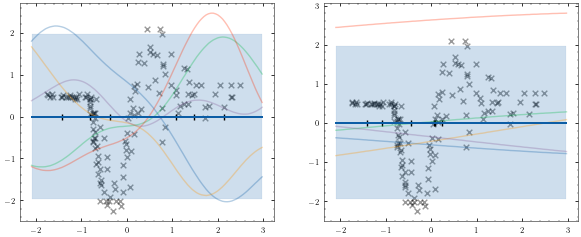

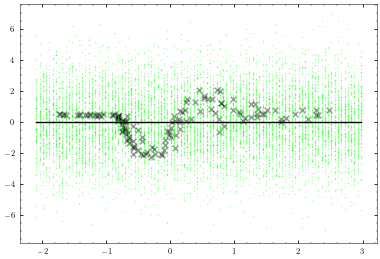

In [10]:
plotter = Plotter1D(model, X, Y)
plotter.plot_model()

Keras makes training/checkpointing/saving/loading the model super easy! This is the main reason I wanted to use keras. We first configure the training/logging parameters. We will use the Adam optimizer to train the model with SGD. Let's now specify the relevant training parameters.

In [ ]:
num_epochs = 2500
batch_size = 16
learning_rate = 0.01
num_samples = 1  # number of samples to draw from variational posterior in ELBO
ckpt_dir = "./ckpts"
log_dir = "./logs"

We can easily use keras callbacks to monitor the model in TensorBorad and checkpoint the model during training.

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer)

In [ ]:
checkpointer_cb = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_dir, monitor="loss")
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq="epoch",
)
callbacks = [tensorboard_cb, checkpointer_cb]
callbacks = [tensorboard_cb]
callbacks = []

In [ ]:
# history = model.fit(X, Y, epochs=num_epochs, batch_size=batch_size, validation_split=0.2, callbacks=callbacks)
history = model.fit(X, Y, epochs=num_epochs, batch_size=batch_size)

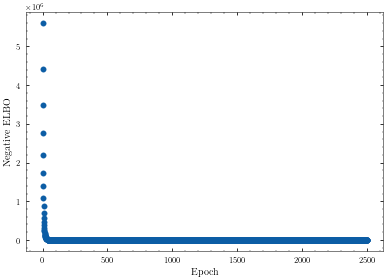

In [17]:
def plot_elbo(negative_elbo):
    plt.subplot(111)
    plt.scatter(np.arange(len(negative_elbo)), negative_elbo)
    plt.xlabel("Epoch")
    plt.ylabel("Negative ELBO")
plot_elbo(history.history["loss"])
# print_summary(expert, fmt="notebook")

Now that we have trained the model we can use our plotter again to visualise what we have learned.

In [ ]:
plotter.plot_model()

## Saving/Loading

The model can easily be saved using keras as I have implemented the `get_config`/`from_config` methods for all components of the model (including some GPflow kernels/mean_functions/likelihoods/inducing_variables). Let's save the model...

In [ ]:
save_dir = "./saved_models/two_experts"
model(X)
model.save(save_dir)

The saved model can then be loaded in multiple ways using Keras,
1. Load the saved model with its `call` method but no other attributes/methods. This can get you out of tricky situations, when the code base has changed and keras cannot instantiate the model using the `get_config`/`from_config` methods. The model can still make predictions but it is not a instance of its original class so does not have its attributes and methods, just its `call` function.
2. Instantiate the models class using the saved config files.

Option 2 is preferred. Let's now demonstrate both approaches.

In [ ]:
loaded_model = tf.keras.models.load_model(save_dir)
np.testing.assert_allclose(loaded_model(X[0:15, :]), model(X[0:15, :]))
print(type(loaded_model))

In this case `loaded_model` is not instance of `MixtureOfSVGPExpert` so `plot_model()` will fail because it tries to acess `MixtureOfSVGPExperts` attributes.

In [ ]:
plotter = Plotter1D(loaded_model, X, Y)
plotter.plot_model()

Alternatively, the saved model can be used to create an instance of `MixtureOfSVGPExperts` using the following.

In [ ]:
loaded_model = tf.keras.models.load_model(save_dir, custom_objects={"MixtureOfSVGPExperts": MixtureOfSVGPExperts})
np.testing.assert_allclose(loaded_model(X), model(X))
print(type(loaded_model))

`loaded_model` is now an instance of `MixtureOfSVGPExpert` so all of its attributes and methods can be called. Let's plot the model to check that they are actually there!

In [ ]:
plotter = Plotter1D(loaded_model, X, Y)
plotter.plot_model()

## YAML configuration

It is also convenient to instantiate models from YAML config files. I have setup the `get_config`/`from_config` methods to instantiate classes with their defaults values if they are not supplied (note that non optional arguments must be set). Further to this, specifying large arrays, e.g. `q_mu`/`q_sqrt`/`Z`, is not very user friendly... 
I have enabled the inducing_inputs (inducing_variable.Z) to be set by specifying the number of inducing points and the input dimensionality. The YAML config looks as follows:
```
inducing_variable:
  class_name: InducingPoints
  config:
    num_inducing: 10
    input_dim: 1
```

In [37]:
yaml_cfg_filename = "./keras_configs/two_experts.yaml"
model_from_cfg = model_from_yaml(yaml_cfg_filename, custom_objects={"MixtureOfSVGPExperts": MixtureOfSVGPExperts})

In [12]:
model_from_cfg(X)
model_from_cfg.summary()

tfp.distributions.Categorical("MoSVGPE_gp_gating_network_ExpertIndicatorCategorical", batch_shape=[133], event_shape=[], dtype=int32)
(133, 2)
<class 'tensorflow_probability.python.distributions.categorical.Categorical'>
Model: "MoSVGPE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SVGPExpert (SVGPExpert)      multiple                  79        
_________________________________________________________________
SVGPExpert (SVGPExpert)      multiple                  79        
_________________________________________________________________
gp_gating_network (SVGPGatin multiple                  78        
Total params: 242
Trainable params: 236
Non-trainable params: 6
_________________________________________________________________


In [13]:
def sample_mosvgpe_inducing_inputs_from_data(X, model):
    for expert in  model.experts_list:
        expert.gp.inducing_variable.Z.assign(sample_inducing_inputs_from_data(X, expert.gp.inducing_variable.Z.shape[0]))
    model.gating_network.gp.inducing_variable.Z.assign(sample_inducing_inputs_from_data(X, model.gating_network.gp.inducing_variable.Z.shape[0]))
    
sample_mosvgpe_inducing_inputs_from_data(X, model_from_cfg)

In [23]:
num_epochs = 3500
batch_size = 32
learning_rate = 0.01
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
model_from_cfg.compile(optimizer=optimizer)

We can easily use keras callbacks to monitor the model in TensorBorad and checkpoint the model during training.

In [24]:
# history = model_from_cfg.fit(X, Y, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)
history = model_from_cfg.fit(X, Y, epochs=num_epochs, batch_size=batch_size)

Epoch 1/3500
Mixing probs: (1, None, 2)
Y.shape
(None, 1)
(1, None, 1)
Experts probs[0]: (None, None)
Experts probs[0]: (None, None)
Experts probs: (None, None, 2)
Experts probs EXP: (None, 1, None, 1, 2)
Mixing probs EXP: (1, 1, None, 2, 1)
Matmul EXP: (None, 1, None, 1, 1)
Marginalised indicator variable: (None, 1, None)
Mixing probs: (1, None, 2)
Y.shape
(None, 1)
(1, None, 1)
Experts probs[0]: (None, None)
Experts probs[0]: (None, None)
Experts probs: (None, None, 2)
Experts probs EXP: (None, 1, None, 1, 2)
Mixing probs EXP: (1, 1, None, 2, 1)
Matmul EXP: (None, 1, None, 1, 1)
Marginalised indicator variable: (None, 1, None)
5/5 [==============================] - 9s 3ms/step - loss: 770.3883 - gating_kl: 1585.9377 - experts_kl: 9735.6089
Epoch 2/3500
5/5 [==============================] - 0s 4ms/step - loss: 429.1174 - gating_kl: 1585.3044 - experts_kl: 9731.9447
Epoch 3/3500
5/5 [==============================] - 0s 4ms/step - loss: 264.5359 - gating_kl: 1584.6716 - experts_kl: 97

5/5 [==============================] - 0s 4ms/step - loss: 37.3908 - gating_kl: 1550.6271 - experts_kl: 9519.5941
Epoch 59/3500
5/5 [==============================] - 0s 4ms/step - loss: 34.7883 - gating_kl: 1550.0216 - experts_kl: 9515.8769
Epoch 60/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.3419 - gating_kl: 1549.4165 - experts_kl: 9512.1625
Epoch 61/3500
5/5 [==============================] - 0s 4ms/step - loss: 36.6393 - gating_kl: 1548.8120 - experts_kl: 9508.4511
Epoch 62/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.6138 - gating_kl: 1548.2080 - experts_kl: 9504.7425
Epoch 63/3500
5/5 [==============================] - 0s 4ms/step - loss: 31.6500 - gating_kl: 1547.6044 - experts_kl: 9501.0369
Epoch 64/3500
5/5 [==============================] - 0s 4ms/step - loss: 34.2193 - gating_kl: 1547.0012 - experts_kl: 9497.3341
Epoch 65/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.3585 - gating_kl: 1546.3986 - experts_kl: 

5/5 [==============================] - 0s 4ms/step - loss: 33.4327 - gating_kl: 1513.3835 - experts_kl: 9290.9424
Epoch 122/3500
5/5 [==============================] - 0s 4ms/step - loss: 32.3141 - gating_kl: 1512.8068 - experts_kl: 9287.4015
Epoch 123/3500
5/5 [==============================] - 0s 4ms/step - loss: 31.0446 - gating_kl: 1512.2305 - experts_kl: 9283.8632
Epoch 124/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.0456 - gating_kl: 1511.6547 - experts_kl: 9280.3277
Epoch 125/3500
5/5 [==============================] - 0s 3ms/step - loss: 30.7378 - gating_kl: 1511.0793 - experts_kl: 9276.7948
Epoch 126/3500
5/5 [==============================] - 0s 4ms/step - loss: 37.8273 - gating_kl: 1510.5043 - experts_kl: 9273.2647
Epoch 127/3500
5/5 [==============================] - 0s 4ms/step - loss: 29.0429 - gating_kl: 1509.9298 - experts_kl: 9269.7373
Epoch 128/3500
5/5 [==============================] - 0s 4ms/step - loss: 31.7124 - gating_kl: 1509.3557 - exper

5/5 [==============================] - 0s 4ms/step - loss: 34.0297 - gating_kl: 1477.8896 - experts_kl: 9073.0275
Epoch 185/3500
5/5 [==============================] - 0s 4ms/step - loss: 32.0299 - gating_kl: 1477.3397 - experts_kl: 9069.6507
Epoch 186/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.9408 - gating_kl: 1476.7902 - experts_kl: 9066.2765
Epoch 187/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.5962 - gating_kl: 1476.2410 - experts_kl: 9062.9048
Epoch 188/3500
5/5 [==============================] - 0s 4ms/step - loss: 32.2773 - gating_kl: 1475.6923 - experts_kl: 9059.5356
Epoch 189/3500
5/5 [==============================] - 0s 4ms/step - loss: 29.8922 - gating_kl: 1475.1440 - experts_kl: 9056.1690
Epoch 190/3500
5/5 [==============================] - 0s 4ms/step - loss: 32.5443 - gating_kl: 1474.5961 - experts_kl: 9052.8049
Epoch 191/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.6312 - gating_kl: 1474.0485 - exper

5/5 [==============================] - 0s 3ms/step - loss: 30.5194 - gating_kl: 1444.0233 - experts_kl: 8865.1023
Epoch 248/3500
5/5 [==============================] - 0s 4ms/step - loss: 31.7182 - gating_kl: 1443.4982 - experts_kl: 8861.8789
Epoch 249/3500
5/5 [==============================] - 0s 3ms/step - loss: 34.7373 - gating_kl: 1442.9735 - experts_kl: 8858.6577
Epoch 250/3500
5/5 [==============================] - 0s 3ms/step - loss: 30.0419 - gating_kl: 1442.4492 - experts_kl: 8855.4389
Epoch 251/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.2219 - gating_kl: 1441.9253 - experts_kl: 8852.2225
Epoch 252/3500
5/5 [==============================] - 0s 3ms/step - loss: 33.7019 - gating_kl: 1441.4018 - experts_kl: 8849.0087
Epoch 253/3500
5/5 [==============================] - 0s 4ms/step - loss: 34.1817 - gating_kl: 1440.8787 - experts_kl: 8845.7971
Epoch 254/3500
5/5 [==============================] - 0s 4ms/step - loss: 34.0787 - gating_kl: 1440.3559 - exper

5/5 [==============================] - 0s 4ms/step - loss: 32.5407 - gating_kl: 1411.6761 - experts_kl: 8666.5097
Epoch 311/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.5154 - gating_kl: 1411.1743 - experts_kl: 8663.4292
Epoch 312/3500
5/5 [==============================] - 0s 4ms/step - loss: 31.4548 - gating_kl: 1410.6729 - experts_kl: 8660.3510
Epoch 313/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.6138 - gating_kl: 1410.1719 - experts_kl: 8657.2750
Epoch 314/3500
5/5 [==============================] - 0s 4ms/step - loss: 32.7944 - gating_kl: 1409.6712 - experts_kl: 8654.2013
Epoch 315/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.0762 - gating_kl: 1409.1709 - experts_kl: 8651.1299
Epoch 316/3500
5/5 [==============================] - 0s 4ms/step - loss: 35.2988 - gating_kl: 1408.6709 - experts_kl: 8648.0609
Epoch 317/3500
5/5 [==============================] - 0s 3ms/step - loss: 33.4714 - gating_kl: 1408.1713 - exper

5/5 [==============================] - 0s 4ms/step - loss: 30.6053 - gating_kl: 1380.7484 - experts_kl: 8476.6299
Epoch 374/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.5426 - gating_kl: 1380.2684 - experts_kl: 8473.6829
Epoch 375/3500
5/5 [==============================] - 0s 4ms/step - loss: 31.3610 - gating_kl: 1379.7887 - experts_kl: 8470.7379
Epoch 376/3500
5/5 [==============================] - 0s 4ms/step - loss: 31.2454 - gating_kl: 1379.3094 - experts_kl: 8467.7951
Epoch 377/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.1329 - gating_kl: 1378.8304 - experts_kl: 8464.8543
Epoch 378/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.0301 - gating_kl: 1378.3517 - experts_kl: 8461.9156
Epoch 379/3500
5/5 [==============================] - 0s 3ms/step - loss: 32.7901 - gating_kl: 1377.8734 - experts_kl: 8458.9789
Epoch 380/3500
5/5 [==============================] - 0s 3ms/step - loss: 32.1737 - gating_kl: 1377.3954 - exper

5/5 [==============================] - 0s 4ms/step - loss: 33.1860 - gating_kl: 1351.1464 - experts_kl: 8294.9142
Epoch 437/3500
5/5 [==============================] - 0s 4ms/step - loss: 34.1498 - gating_kl: 1350.6868 - experts_kl: 8292.0933
Epoch 438/3500
5/5 [==============================] - 0s 4ms/step - loss: 34.2669 - gating_kl: 1350.2274 - experts_kl: 8289.2749
Epoch 439/3500
5/5 [==============================] - 0s 4ms/step - loss: 48.2267 - gating_kl: 1349.7684 - experts_kl: 8286.4613
Epoch 440/3500
5/5 [==============================] - 0s 4ms/step - loss: 35.5096 - gating_kl: 1349.3097 - experts_kl: 8283.6483
Epoch 441/3500
5/5 [==============================] - 0s 5ms/step - loss: 33.3438 - gating_kl: 1348.8513 - experts_kl: 8280.8355
Epoch 442/3500
5/5 [==============================] - 0s 4ms/step - loss: 32.0152 - gating_kl: 1348.3932 - experts_kl: 8278.0242
Epoch 443/3500
5/5 [==============================] - 0s 4ms/step - loss: 37.4346 - gating_kl: 1347.9355 - exper

5/5 [==============================] - 0s 4ms/step - loss: 33.6937 - gating_kl: 1322.7894 - experts_kl: 8121.0983
Epoch 500/3500
5/5 [==============================] - 0s 4ms/step - loss: 31.8893 - gating_kl: 1322.3489 - experts_kl: 8118.3941
Epoch 501/3500
5/5 [==============================] - 0s 4ms/step - loss: 31.4453 - gating_kl: 1321.9087 - experts_kl: 8115.6916
Epoch 502/3500
5/5 [==============================] - 0s 5ms/step - loss: 31.9508 - gating_kl: 1321.4688 - experts_kl: 8112.9908
Epoch 503/3500
5/5 [==============================] - 0s 5ms/step - loss: 31.4371 - gating_kl: 1321.0292 - experts_kl: 8110.2919
Epoch 504/3500
5/5 [==============================] - 0s 5ms/step - loss: 34.7405 - gating_kl: 1320.5899 - experts_kl: 8107.5947
Epoch 505/3500
5/5 [==============================] - 0s 4ms/step - loss: 35.2198 - gating_kl: 1320.1509 - experts_kl: 8104.8993
Epoch 506/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.1830 - gating_kl: 1319.7121 - exper

5/5 [==============================] - 0s 4ms/step - loss: 34.0834 - gating_kl: 1295.6003 - experts_kl: 7954.1675
Epoch 563/3500
5/5 [==============================] - 0s 4ms/step - loss: 34.4853 - gating_kl: 1295.1777 - experts_kl: 7951.5732
Epoch 564/3500
5/5 [==============================] - 0s 4ms/step - loss: 29.7960 - gating_kl: 1294.7555 - experts_kl: 7948.9806
Epoch 565/3500
5/5 [==============================] - 0s 4ms/step - loss: 35.7931 - gating_kl: 1294.3335 - experts_kl: 7946.3895
Epoch 566/3500
5/5 [==============================] - 0s 4ms/step - loss: 31.5799 - gating_kl: 1293.9118 - experts_kl: 7943.8002
Epoch 567/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.2142 - gating_kl: 1293.4903 - experts_kl: 7941.2128
Epoch 568/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.9230 - gating_kl: 1293.0691 - experts_kl: 7938.6273
Epoch 569/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.5605 - gating_kl: 1292.6482 - exper

5/5 [==============================] - 0s 4ms/step - loss: 28.9191 - gating_kl: 1269.5078 - experts_kl: 7793.9663
Epoch 626/3500
5/5 [==============================] - 0s 5ms/step - loss: 31.6741 - gating_kl: 1269.1020 - experts_kl: 7791.4758
Epoch 627/3500
5/5 [==============================] - 0s 4ms/step - loss: 34.3951 - gating_kl: 1268.6966 - experts_kl: 7788.9875
Epoch 628/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.4680 - gating_kl: 1268.2914 - experts_kl: 7786.5000
Epoch 629/3500
5/5 [==============================] - 0s 4ms/step - loss: 29.9934 - gating_kl: 1267.8864 - experts_kl: 7784.0140
Epoch 630/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.4302 - gating_kl: 1267.4817 - experts_kl: 7781.5294
Epoch 631/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.5711 - gating_kl: 1267.0772 - experts_kl: 7779.0463
Epoch 632/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.9049 - gating_kl: 1266.6730 - exper

5/5 [==============================] - 0s 4ms/step - loss: 29.8617 - gating_kl: 1244.4459 - experts_kl: 7640.1016
Epoch 689/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.8028 - gating_kl: 1244.0561 - experts_kl: 7637.7080
Epoch 690/3500
5/5 [==============================] - 0s 4ms/step - loss: 31.7456 - gating_kl: 1243.6666 - experts_kl: 7635.3159
Epoch 691/3500
5/5 [==============================] - 0s 4ms/step - loss: 31.0808 - gating_kl: 1243.2773 - experts_kl: 7632.9254
Epoch 692/3500
5/5 [==============================] - 0s 4ms/step - loss: 31.0428 - gating_kl: 1242.8882 - experts_kl: 7630.5365
Epoch 693/3500
5/5 [==============================] - 0s 5ms/step - loss: 32.4276 - gating_kl: 1242.4994 - experts_kl: 7628.1492
Epoch 694/3500
5/5 [==============================] - 0s 5ms/step - loss: 31.1664 - gating_kl: 1242.1108 - experts_kl: 7625.7637
Epoch 695/3500
5/5 [==============================] - 0s 4ms/step - loss: 32.5846 - gating_kl: 1241.7225 - exper

5/5 [==============================] - 0s 4ms/step - loss: 34.0436 - gating_kl: 1220.3579 - experts_kl: 7492.1974
Epoch 752/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.7552 - gating_kl: 1219.9831 - experts_kl: 7489.8972
Epoch 753/3500
5/5 [==============================] - 0s 4ms/step - loss: 29.1494 - gating_kl: 1219.6085 - experts_kl: 7487.5973
Epoch 754/3500
5/5 [==============================] - 0s 4ms/step - loss: 31.8671 - gating_kl: 1219.2342 - experts_kl: 7485.2986
Epoch 755/3500
5/5 [==============================] - 0s 4ms/step - loss: 32.5100 - gating_kl: 1218.8601 - experts_kl: 7483.0011
Epoch 756/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.7129 - gating_kl: 1218.4862 - experts_kl: 7480.7051
Epoch 757/3500
5/5 [==============================] - 0s 4ms/step - loss: 31.3933 - gating_kl: 1218.1126 - experts_kl: 7478.4103
Epoch 758/3500
5/5 [==============================] - 0s 4ms/step - loss: 29.7079 - gating_kl: 1217.7392 - exper

5/5 [==============================] - 0s 4ms/step - loss: 29.4554 - gating_kl: 1197.1891 - experts_kl: 7349.9145
Epoch 815/3500
5/5 [==============================] - 0s 4ms/step - loss: 32.8793 - gating_kl: 1196.8284 - experts_kl: 7347.6997
Epoch 816/3500
5/5 [==============================] - 0s 4ms/step - loss: 31.7154 - gating_kl: 1196.4679 - experts_kl: 7345.4862
Epoch 817/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.6181 - gating_kl: 1196.1077 - experts_kl: 7343.2740
Epoch 818/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.9273 - gating_kl: 1195.7476 - experts_kl: 7341.0632
Epoch 819/3500
5/5 [==============================] - 0s 4ms/step - loss: 29.7421 - gating_kl: 1195.3878 - experts_kl: 7338.8536
Epoch 820/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.9536 - gating_kl: 1195.0282 - experts_kl: 7336.6456
Epoch 821/3500
5/5 [==============================] - 0s 4ms/step - loss: 32.8229 - gating_kl: 1194.6688 - exper

5/5 [==============================] - 0s 4ms/step - loss: 36.8123 - gating_kl: 1174.8847 - experts_kl: 7212.9386
Epoch 878/3500
5/5 [==============================] - 0s 4ms/step - loss: 43.0446 - gating_kl: 1174.5373 - experts_kl: 7210.8073
Epoch 879/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.6223 - gating_kl: 1174.1902 - experts_kl: 7208.6770
Epoch 880/3500
5/5 [==============================] - 0s 5ms/step - loss: 32.6621 - gating_kl: 1173.8433 - experts_kl: 7206.5470
Epoch 881/3500
5/5 [==============================] - 0s 4ms/step - loss: 34.0563 - gating_kl: 1173.4966 - experts_kl: 7204.4180
Epoch 882/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.3111 - gating_kl: 1173.1501 - experts_kl: 7202.2902
Epoch 883/3500
5/5 [==============================] - 0s 5ms/step - loss: 29.8965 - gating_kl: 1172.8038 - experts_kl: 7200.1634
Epoch 884/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.7667 - gating_kl: 1172.4577 - exper

5/5 [==============================] - 0s 5ms/step - loss: 39.2526 - gating_kl: 1153.3987 - experts_kl: 7080.9834
Epoch 941/3500
5/5 [==============================] - 0s 5ms/step - loss: 31.7518 - gating_kl: 1153.0640 - experts_kl: 7078.9290
Epoch 942/3500
5/5 [==============================] - 0s 6ms/step - loss: 29.1918 - gating_kl: 1152.7295 - experts_kl: 7076.8748
Epoch 943/3500
5/5 [==============================] - 0s 4ms/step - loss: 31.1018 - gating_kl: 1152.3951 - experts_kl: 7074.8218
Epoch 944/3500
5/5 [==============================] - 0s 5ms/step - loss: 33.5798 - gating_kl: 1152.0610 - experts_kl: 7072.7698
Epoch 945/3500
5/5 [==============================] - 0s 5ms/step - loss: 29.8955 - gating_kl: 1151.7271 - experts_kl: 7070.7189
Epoch 946/3500
5/5 [==============================] - 0s 6ms/step - loss: 27.8110 - gating_kl: 1151.3934 - experts_kl: 7068.6691
Epoch 947/3500
5/5 [==============================] - 0s 5ms/step - loss: 27.7975 - gating_kl: 1151.0599 - exper

5/5 [==============================] - 0s 4ms/step - loss: 30.4490 - gating_kl: 1132.6871 - experts_kl: 6953.7744
Epoch 1004/3500
5/5 [==============================] - 0s 4ms/step - loss: 29.5493 - gating_kl: 1132.3644 - experts_kl: 6951.7921
Epoch 1005/3500
5/5 [==============================] - 0s 4ms/step - loss: 27.1718 - gating_kl: 1132.0419 - experts_kl: 6949.8109
Epoch 1006/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.9634 - gating_kl: 1131.7195 - experts_kl: 6947.8307
Epoch 1007/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.5777 - gating_kl: 1131.3973 - experts_kl: 6945.8516
Epoch 1008/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.7688 - gating_kl: 1131.0753 - experts_kl: 6943.8735
Epoch 1009/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.1915 - gating_kl: 1130.7534 - experts_kl: 6941.8966
Epoch 1010/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.0015 - gating_kl: 1130.4318 

5/5 [==============================] - 0s 4ms/step - loss: 30.1165 - gating_kl: 1112.7077 - experts_kl: 6831.0545
Epoch 1067/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.2156 - gating_kl: 1112.3962 - experts_kl: 6829.1412
Epoch 1068/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.7864 - gating_kl: 1112.0850 - experts_kl: 6827.2289
Epoch 1069/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.4942 - gating_kl: 1111.7739 - experts_kl: 6825.3178
Epoch 1070/3500
5/5 [==============================] - 0s 3ms/step - loss: 32.2758 - gating_kl: 1111.4630 - experts_kl: 6823.4080
Epoch 1071/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.1129 - gating_kl: 1111.1522 - experts_kl: 6821.4997
Epoch 1072/3500
5/5 [==============================] - 0s 4ms/step - loss: 34.8668 - gating_kl: 1110.8417 - experts_kl: 6819.5927
Epoch 1073/3500
5/5 [==============================] - 0s 4ms/step - loss: 35.3498 - gating_kl: 1110.5313 

5/5 [==============================] - 0s 4ms/step - loss: 27.4351 - gating_kl: 1093.7232 - experts_kl: 6714.4463
Epoch 1129/3500
5/5 [==============================] - 0s 4ms/step - loss: 27.8601 - gating_kl: 1093.4223 - experts_kl: 6712.5980
Epoch 1130/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.2700 - gating_kl: 1093.1216 - experts_kl: 6710.7507
Epoch 1131/3500
5/5 [==============================] - ETA: 0s - loss: 33.1306 - gating_kl: 1092.9612 - experts_kl: 6709.765 - 0s 5ms/step - loss: 28.4915 - gating_kl: 1092.8210 - experts_kl: 6708.9043
Epoch 1132/3500
5/5 [==============================] - 0s 6ms/step - loss: 34.4173 - gating_kl: 1092.5206 - experts_kl: 6707.0590
Epoch 1133/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.0383 - gating_kl: 1092.2204 - experts_kl: 6705.2148
Epoch 1134/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.5329 - gating_kl: 1091.9203 - experts_kl: 6703.3715
Epoch 1135/3500
5/5 [=============

5/5 [==============================] - 0s 4ms/step - loss: 30.3137 - gating_kl: 1075.3760 - experts_kl: 6601.7553
Epoch 1191/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.1326 - gating_kl: 1075.0852 - experts_kl: 6599.9685
Epoch 1192/3500
5/5 [==============================] - 0s 4ms/step - loss: 35.7295 - gating_kl: 1074.7946 - experts_kl: 6598.1827
Epoch 1193/3500
5/5 [==============================] - 0s 4ms/step - loss: 29.6670 - gating_kl: 1074.5041 - experts_kl: 6596.3979
Epoch 1194/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.1308 - gating_kl: 1074.2138 - experts_kl: 6594.6142
Epoch 1195/3500
5/5 [==============================] - 0s 4ms/step - loss: 32.1331 - gating_kl: 1073.9236 - experts_kl: 6592.8315
Epoch 1196/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.0887 - gating_kl: 1073.6335 - experts_kl: 6591.0499
Epoch 1197/3500
5/5 [==============================] - 0s 4ms/step - loss: 34.4335 - gating_kl: 1073.3436 

5/5 [==============================] - 0s 4ms/step - loss: 30.1004 - gating_kl: 1057.3564 - experts_kl: 6491.0597
Epoch 1254/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.9584 - gating_kl: 1057.0752 - experts_kl: 6489.3327
Epoch 1255/3500
5/5 [==============================] - 0s 4ms/step - loss: 29.7864 - gating_kl: 1056.7942 - experts_kl: 6487.6064
Epoch 1256/3500
5/5 [==============================] - 0s 4ms/step - loss: 29.1032 - gating_kl: 1056.5133 - experts_kl: 6485.8809
Epoch 1257/3500
5/5 [==============================] - 0s 4ms/step - loss: 27.5179 - gating_kl: 1056.2326 - experts_kl: 6484.1564
Epoch 1258/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.6050 - gating_kl: 1055.9520 - experts_kl: 6482.4326
Epoch 1259/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.0874 - gating_kl: 1055.6716 - experts_kl: 6480.7098
Epoch 1260/3500
5/5 [==============================] - 0s 5ms/step - loss: 27.6981 - gating_kl: 1055.3913 

5/5 [==============================] - 0s 4ms/step - loss: 31.3358 - gating_kl: 1039.9329 - experts_kl: 6384.0151
Epoch 1317/3500
5/5 [==============================] - 0s 4ms/step - loss: 29.6947 - gating_kl: 1039.6610 - experts_kl: 6382.3450
Epoch 1318/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.0301 - gating_kl: 1039.3892 - experts_kl: 6380.6758
Epoch 1319/3500
5/5 [==============================] - 0s 4ms/step - loss: 27.6313 - gating_kl: 1039.1176 - experts_kl: 6379.0069
Epoch 1320/3500
5/5 [==============================] - 0s 4ms/step - loss: 33.6329 - gating_kl: 1038.8461 - experts_kl: 6377.3389
Epoch 1321/3500
5/5 [==============================] - 0s 5ms/step - loss: 30.7491 - gating_kl: 1038.5747 - experts_kl: 6375.6719
Epoch 1322/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.4661 - gating_kl: 1038.3034 - experts_kl: 6374.0057
Epoch 1323/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.7053 - gating_kl: 1038.0324 

5/5 [==============================] - 0s 4ms/step - loss: 29.3983 - gating_kl: 1023.0778 - experts_kl: 6280.4536
Epoch 1380/3500
5/5 [==============================] - 0s 4ms/step - loss: 32.2363 - gating_kl: 1022.8147 - experts_kl: 6278.8366
Epoch 1381/3500
5/5 [==============================] - 0s 4ms/step - loss: 29.6811 - gating_kl: 1022.5518 - experts_kl: 6277.2204
Epoch 1382/3500
5/5 [==============================] - 0s 4ms/step - loss: 29.6118 - gating_kl: 1022.2889 - experts_kl: 6275.6051
Epoch 1383/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.0607 - gating_kl: 1022.0263 - experts_kl: 6273.9906
Epoch 1384/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.4610 - gating_kl: 1021.7637 - experts_kl: 6272.3769
Epoch 1385/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.8743 - gating_kl: 1021.5014 - experts_kl: 6270.7641
Epoch 1386/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.0553 - gating_kl: 1021.2391 

5/5 [==============================] - 0s 4ms/step - loss: 29.8511 - gating_kl: 1006.7673 - experts_kl: 6180.1933
Epoch 1443/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.5615 - gating_kl: 1006.5127 - experts_kl: 6178.6278
Epoch 1444/3500
5/5 [==============================] - 0s 4ms/step - loss: 27.6526 - gating_kl: 1006.2582 - experts_kl: 6177.0629
Epoch 1445/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.6656 - gating_kl: 1006.0038 - experts_kl: 6175.4988
Epoch 1446/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.6284 - gating_kl: 1005.7496 - experts_kl: 6173.9355
Epoch 1447/3500
5/5 [==============================] - 0s 4ms/step - loss: 24.7339 - gating_kl: 1005.4955 - experts_kl: 6172.3728
Epoch 1448/3500
5/5 [==============================] - 0s 4ms/step - loss: 29.3986 - gating_kl: 1005.2415 - experts_kl: 6170.8109
Epoch 1449/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.4125 - gating_kl: 1004.9876 

5/5 [==============================] - 0s 4ms/step - loss: 28.8196 - gating_kl: 990.9753 - experts_kl: 6083.0825
Epoch 1506/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.4211 - gating_kl: 990.7287 - experts_kl: 6081.5656
Epoch 1507/3500
5/5 [==============================] - 0s 4ms/step - loss: 27.3573 - gating_kl: 990.4822 - experts_kl: 6080.0495
Epoch 1508/3500
5/5 [==============================] - 0s 4ms/step - loss: 29.2507 - gating_kl: 990.2359 - experts_kl: 6078.5343
Epoch 1509/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.4984 - gating_kl: 989.9897 - experts_kl: 6077.0198
Epoch 1510/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.7696 - gating_kl: 989.7436 - experts_kl: 6075.5060
Epoch 1511/3500
5/5 [==============================] - 0s 4ms/step - loss: 31.7411 - gating_kl: 989.4976 - experts_kl: 6073.9930
Epoch 1512/3500
5/5 [==============================] - 0s 4ms/step - loss: 29.0866 - gating_kl: 989.2517 - expert

5/5 [==============================] - 0s 4ms/step - loss: 26.5855 - gating_kl: 975.6774 - experts_kl: 5988.9857
Epoch 1569/3500
5/5 [==============================] - 0s 5ms/step - loss: 30.6916 - gating_kl: 975.4384 - experts_kl: 5987.5154
Epoch 1570/3500
5/5 [==============================] - 0s 5ms/step - loss: 30.7643 - gating_kl: 975.1996 - experts_kl: 5986.0458
Epoch 1571/3500
5/5 [==============================] - 0s 5ms/step - loss: 29.4527 - gating_kl: 974.9609 - experts_kl: 5984.5769
Epoch 1572/3500
5/5 [==============================] - 0s 5ms/step - loss: 26.4689 - gating_kl: 974.7223 - experts_kl: 5983.1088
Epoch 1573/3500
5/5 [==============================] - 0s 5ms/step - loss: 26.4456 - gating_kl: 974.4838 - experts_kl: 5981.6414
Epoch 1574/3500
5/5 [==============================] - 0s 5ms/step - loss: 25.5085 - gating_kl: 974.2454 - experts_kl: 5980.1747
Epoch 1575/3500
5/5 [==============================] - 0s 4ms/step - loss: 30.6796 - gating_kl: 974.0072 - expert

5/5 [==============================] - 0s 4ms/step - loss: 27.9764 - gating_kl: 960.8470 - experts_kl: 5897.7405
Epoch 1632/3500
5/5 [==============================] - 0s 4ms/step - loss: 27.8586 - gating_kl: 960.6153 - experts_kl: 5896.3146
Epoch 1633/3500
5/5 [==============================] - 0s 4ms/step - loss: 25.4813 - gating_kl: 960.3836 - experts_kl: 5894.8894
Epoch 1634/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.1433 - gating_kl: 960.1520 - experts_kl: 5893.4649
Epoch 1635/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.1950 - gating_kl: 959.9206 - experts_kl: 5892.0410
Epoch 1636/3500
5/5 [==============================] - 0s 4ms/step - loss: 25.7706 - gating_kl: 959.6893 - experts_kl: 5890.6179
Epoch 1637/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.1640 - gating_kl: 959.4580 - experts_kl: 5889.1954
Epoch 1638/3500
5/5 [==============================] - 0s 4ms/step - loss: 26.3406 - gating_kl: 959.2269 - expert

5/5 [==============================] - 0s 4ms/step - loss: 26.7298 - gating_kl: 946.4609 - experts_kl: 5809.2357
Epoch 1695/3500
5/5 [==============================] - 0s 4ms/step - loss: 25.7339 - gating_kl: 946.2361 - experts_kl: 5807.8522
Epoch 1696/3500
5/5 [==============================] - 0s 4ms/step - loss: 27.0802 - gating_kl: 946.0114 - experts_kl: 5806.4695
Epoch 1697/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.4700 - gating_kl: 945.7867 - experts_kl: 5805.0874
Epoch 1698/3500
5/5 [==============================] - 0s 4ms/step - loss: 26.9596 - gating_kl: 945.5622 - experts_kl: 5803.7060
Epoch 1699/3500
5/5 [==============================] - 0s 4ms/step - loss: 24.7730 - gating_kl: 945.3378 - experts_kl: 5802.3252
Epoch 1700/3500
5/5 [==============================] - 0s 4ms/step - loss: 27.3590 - gating_kl: 945.1135 - experts_kl: 5800.9451
Epoch 1701/3500
5/5 [==============================] - 0s 4ms/step - loss: 25.6931 - gating_kl: 944.8893 - expert

5/5 [==============================] - 0s 5ms/step - loss: 28.7111 - gating_kl: 932.5018 - experts_kl: 5723.3533
Epoch 1758/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.3906 - gating_kl: 932.2835 - experts_kl: 5722.0106
Epoch 1759/3500
5/5 [==============================] - 0s 4ms/step - loss: 26.1871 - gating_kl: 932.0654 - experts_kl: 5720.6685
Epoch 1760/3500
5/5 [==============================] - 0s 5ms/step - loss: 30.8288 - gating_kl: 931.8474 - experts_kl: 5719.3271
Epoch 1761/3500
5/5 [==============================] - 0s 4ms/step - loss: 27.2996 - gating_kl: 931.6295 - experts_kl: 5717.9864
Epoch 1762/3500
5/5 [==============================] - 0s 5ms/step - loss: 26.9359 - gating_kl: 931.4116 - experts_kl: 5716.6462
Epoch 1763/3500
5/5 [==============================] - 0s 5ms/step - loss: 25.0594 - gating_kl: 931.1939 - experts_kl: 5715.3067
Epoch 1764/3500
5/5 [==============================] - 0s 5ms/step - loss: 24.4049 - gating_kl: 930.9763 - expert

5/5 [==============================] - 0s 5ms/step - loss: 27.6264 - gating_kl: 918.9500 - experts_kl: 5639.9748
Epoch 1821/3500
5/5 [==============================] - 0s 5ms/step - loss: 25.1833 - gating_kl: 918.7381 - experts_kl: 5638.6710
Epoch 1822/3500
5/5 [==============================] - 0s 4ms/step - loss: 26.8446 - gating_kl: 918.5263 - experts_kl: 5637.3679
Epoch 1823/3500
5/5 [==============================] - 0s 5ms/step - loss: 24.9733 - gating_kl: 918.3146 - experts_kl: 5636.0652
Epoch 1824/3500
5/5 [==============================] - 0s 4ms/step - loss: 27.8249 - gating_kl: 918.1029 - experts_kl: 5634.7632
Epoch 1825/3500
5/5 [==============================] - 0s 5ms/step - loss: 26.1681 - gating_kl: 917.8914 - experts_kl: 5633.4618
Epoch 1826/3500
5/5 [==============================] - 0s 4ms/step - loss: 26.9508 - gating_kl: 917.6799 - experts_kl: 5632.1610
Epoch 1827/3500
5/5 [==============================] - 0s 5ms/step - loss: 24.4083 - gating_kl: 917.4686 - expert

5/5 [==============================] - 0s 7ms/step - loss: 25.7735 - gating_kl: 905.7863 - experts_kl: 5558.9955
Epoch 1884/3500
5/5 [==============================] - 0s 6ms/step - loss: 25.7340 - gating_kl: 905.5804 - experts_kl: 5557.7287
Epoch 1885/3500
5/5 [==============================] - 0s 5ms/step - loss: 28.2733 - gating_kl: 905.3745 - experts_kl: 5556.4626
Epoch 1886/3500
5/5 [==============================] - 0s 5ms/step - loss: 26.2582 - gating_kl: 905.1688 - experts_kl: 5555.1970
Epoch 1887/3500
5/5 [==============================] - 0s 5ms/step - loss: 23.8620 - gating_kl: 904.9631 - experts_kl: 5553.9321
Epoch 1888/3500
5/5 [==============================] - 0s 5ms/step - loss: 26.7378 - gating_kl: 904.7576 - experts_kl: 5552.6678
Epoch 1889/3500
5/5 [==============================] - 0s 5ms/step - loss: 28.1307 - gating_kl: 904.5521 - experts_kl: 5551.4041
Epoch 1890/3500
5/5 [==============================] - 0s 5ms/step - loss: 26.6398 - gating_kl: 904.3468 - expert

5/5 [==============================] - 0s 4ms/step - loss: 26.2419 - gating_kl: 892.9959 - experts_kl: 5480.3088
Epoch 1947/3500
5/5 [==============================] - 0s 4ms/step - loss: 25.0862 - gating_kl: 892.7958 - experts_kl: 5479.0779
Epoch 1948/3500
5/5 [==============================] - 0s 5ms/step - loss: 24.5737 - gating_kl: 892.5958 - experts_kl: 5477.8475
Epoch 1949/3500
5/5 [==============================] - 0s 5ms/step - loss: 25.1541 - gating_kl: 892.3959 - experts_kl: 5476.6176
Epoch 1950/3500
5/5 [==============================] - 0s 4ms/step - loss: 24.3561 - gating_kl: 892.1961 - experts_kl: 5475.3883
Epoch 1951/3500
5/5 [==============================] - 0s 5ms/step - loss: 25.3928 - gating_kl: 891.9964 - experts_kl: 5474.1594
Epoch 1952/3500
5/5 [==============================] - 0s 5ms/step - loss: 24.3175 - gating_kl: 891.7968 - experts_kl: 5472.9311
Epoch 1953/3500
5/5 [==============================] - 0s 5ms/step - loss: 25.5579 - gating_kl: 891.5972 - expert

5/5 [==============================] - 0s 5ms/step - loss: 23.5487 - gating_kl: 880.5637 - experts_kl: 5403.8188
Epoch 2010/3500
5/5 [==============================] - 0s 4ms/step - loss: 26.4308 - gating_kl: 880.3692 - experts_kl: 5402.6218
Epoch 2011/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.0386 - gating_kl: 880.1748 - experts_kl: 5401.4253
Epoch 2012/3500
5/5 [==============================] - 0s 5ms/step - loss: 24.2412 - gating_kl: 879.9804 - experts_kl: 5400.2294
Epoch 2013/3500
5/5 [==============================] - 0s 4ms/step - loss: 23.6286 - gating_kl: 879.7862 - experts_kl: 5399.0341
Epoch 2014/3500
5/5 [==============================] - 0s 4ms/step - loss: 25.8285 - gating_kl: 879.5920 - experts_kl: 5397.8392
Epoch 2015/3500
5/5 [==============================] - 0s 5ms/step - loss: 24.5005 - gating_kl: 879.3979 - experts_kl: 5396.6449
Epoch 2016/3500
5/5 [==============================] - 0s 5ms/step - loss: 26.2145 - gating_kl: 879.2039 - expert

5/5 [==============================] - 0s 4ms/step - loss: 23.2855 - gating_kl: 868.4753 - experts_kl: 5329.4378
Epoch 2073/3500
5/5 [==============================] - 0s 4ms/step - loss: 25.4442 - gating_kl: 868.2861 - experts_kl: 5328.2737
Epoch 2074/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.0709 - gating_kl: 868.0970 - experts_kl: 5327.1101
Epoch 2075/3500
5/5 [==============================] - 0s 4ms/step - loss: 24.4999 - gating_kl: 867.9079 - experts_kl: 5325.9470
Epoch 2076/3500
5/5 [==============================] - 0s 4ms/step - loss: 23.7480 - gating_kl: 867.7189 - experts_kl: 5324.7845
Epoch 2077/3500
5/5 [==============================] - 0s 4ms/step - loss: 23.1773 - gating_kl: 867.5300 - experts_kl: 5323.6224
Epoch 2078/3500
5/5 [==============================] - 0s 4ms/step - loss: 25.1899 - gating_kl: 867.3412 - experts_kl: 5322.4608
Epoch 2079/3500
5/5 [==============================] - 0s 4ms/step - loss: 24.2851 - gating_kl: 867.1525 - expert

5/5 [==============================] - 0s 4ms/step - loss: 26.8779 - gating_kl: 856.7133 - experts_kl: 5257.0786
Epoch 2136/3500
5/5 [==============================] - 0s 4ms/step - loss: 26.5206 - gating_kl: 856.5292 - experts_kl: 5255.9458
Epoch 2137/3500
5/5 [==============================] - 0s 4ms/step - loss: 26.9787 - gating_kl: 856.3452 - experts_kl: 5254.8135
Epoch 2138/3500
5/5 [==============================] - 0s 4ms/step - loss: 24.0037 - gating_kl: 856.1612 - experts_kl: 5253.6817
Epoch 2139/3500
5/5 [==============================] - 0s 4ms/step - loss: 25.8320 - gating_kl: 855.9774 - experts_kl: 5252.5504
Epoch 2140/3500
5/5 [==============================] - 0s 4ms/step - loss: 23.9331 - gating_kl: 855.7936 - experts_kl: 5251.4196
Epoch 2141/3500
5/5 [==============================] - 0s 4ms/step - loss: 25.8057 - gating_kl: 855.6099 - experts_kl: 5250.2893
Epoch 2142/3500
5/5 [==============================] - 0s 4ms/step - loss: 25.1520 - gating_kl: 855.4263 - expert

5/5 [==============================] - 0s 4ms/step - loss: 22.9321 - gating_kl: 845.2675 - experts_kl: 5186.6589
Epoch 2199/3500
5/5 [==============================] - 0s 4ms/step - loss: 26.9248 - gating_kl: 845.0883 - experts_kl: 5185.5563
Epoch 2200/3500
5/5 [==============================] - 0s 4ms/step - loss: 27.8451 - gating_kl: 844.9092 - experts_kl: 5184.4543
Epoch 2201/3500
5/5 [==============================] - 0s 4ms/step - loss: 25.2489 - gating_kl: 844.7301 - experts_kl: 5183.3527
Epoch 2202/3500
5/5 [==============================] - 0s 4ms/step - loss: 24.6088 - gating_kl: 844.5511 - experts_kl: 5182.2516
Epoch 2203/3500
5/5 [==============================] - 0s 4ms/step - loss: 24.2229 - gating_kl: 844.3722 - experts_kl: 5181.1509
Epoch 2204/3500
5/5 [==============================] - 0s 4ms/step - loss: 26.1001 - gating_kl: 844.1934 - experts_kl: 5180.0507
Epoch 2205/3500
5/5 [==============================] - 0s 4ms/step - loss: 24.2757 - gating_kl: 844.0147 - expert

5/5 [==============================] - 0s 4ms/step - loss: 23.7292 - gating_kl: 834.1251 - experts_kl: 5118.1063
Epoch 2262/3500
5/5 [==============================] - 0s 4ms/step - loss: 25.1928 - gating_kl: 833.9506 - experts_kl: 5117.0328
Epoch 2263/3500
5/5 [==============================] - 0s 4ms/step - loss: 23.7847 - gating_kl: 833.7762 - experts_kl: 5115.9597
Epoch 2264/3500
5/5 [==============================] - 0s 4ms/step - loss: 26.1189 - gating_kl: 833.6019 - experts_kl: 5114.8870
Epoch 2265/3500
5/5 [==============================] - 0s 4ms/step - loss: 28.9867 - gating_kl: 833.4276 - experts_kl: 5113.8148
Epoch 2266/3500
5/5 [==============================] - 0s 4ms/step - loss: 24.8983 - gating_kl: 833.2534 - experts_kl: 5112.7431
Epoch 2267/3500
5/5 [==============================] - 0s 4ms/step - loss: 25.5140 - gating_kl: 833.0793 - experts_kl: 5111.6719
Epoch 2268/3500
5/5 [==============================] - 0s 4ms/step - loss: 24.6019 - gating_kl: 832.9052 - expert

5/5 [==============================] - 0s 6ms/step - loss: 22.3153 - gating_kl: 823.2760 - experts_kl: 5051.3488
Epoch 2325/3500
5/5 [==============================] - 0s 5ms/step - loss: 23.6189 - gating_kl: 823.1061 - experts_kl: 5050.3032
Epoch 2326/3500
5/5 [==============================] - 0s 6ms/step - loss: 21.9988 - gating_kl: 822.9363 - experts_kl: 5049.2580
Epoch 2327/3500
5/5 [==============================] - 0s 6ms/step - loss: 20.9843 - gating_kl: 822.7665 - experts_kl: 5048.2132
Epoch 2328/3500
5/5 [==============================] - 0s 6ms/step - loss: 21.7381 - gating_kl: 822.5968 - experts_kl: 5047.1689
Epoch 2329/3500
5/5 [==============================] - 0s 7ms/step - loss: 22.6175 - gating_kl: 822.4272 - experts_kl: 5046.1250
Epoch 2330/3500
5/5 [==============================] - 0s 6ms/step - loss: 23.3545 - gating_kl: 822.2576 - experts_kl: 5045.0815
Epoch 2331/3500
5/5 [==============================] - 0s 6ms/step - loss: 24.6887 - gating_kl: 822.0881 - expert

5/5 [==============================] - 0s 6ms/step - loss: 20.0328 - gating_kl: 812.7078 - experts_kl: 4986.3142
Epoch 2388/3500
5/5 [==============================] - 0s 6ms/step - loss: 23.5440 - gating_kl: 812.5422 - experts_kl: 4985.2954
Epoch 2389/3500
5/5 [==============================] - 0s 6ms/step - loss: 23.0278 - gating_kl: 812.3767 - experts_kl: 4984.2770
Epoch 2390/3500
5/5 [==============================] - 0s 5ms/step - loss: 21.0343 - gating_kl: 812.2112 - experts_kl: 4983.2590
Epoch 2391/3500
5/5 [==============================] - 0s 6ms/step - loss: 23.2577 - gating_kl: 812.0459 - experts_kl: 4982.2414
Epoch 2392/3500
5/5 [==============================] - 0s 5ms/step - loss: 20.7634 - gating_kl: 811.8805 - experts_kl: 4981.2242
Epoch 2393/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.4437 - gating_kl: 811.7153 - experts_kl: 4980.2074
Epoch 2394/3500
5/5 [==============================] - 0s 6ms/step - loss: 20.9966 - gating_kl: 811.5501 - expert

5/5 [==============================] - 0s 6ms/step - loss: 23.8338 - gating_kl: 802.4090 - experts_kl: 4922.9309
Epoch 2451/3500
5/5 [==============================] - 0s 5ms/step - loss: 24.4496 - gating_kl: 802.2476 - experts_kl: 4921.9379
Epoch 2452/3500
5/5 [==============================] - 0s 5ms/step - loss: 23.0007 - gating_kl: 802.0864 - experts_kl: 4920.9452
Epoch 2453/3500
5/5 [==============================] - 0s 4ms/step - loss: 23.3100 - gating_kl: 801.9251 - experts_kl: 4919.9529
Epoch 2454/3500
5/5 [==============================] - 0s 4ms/step - loss: 22.3735 - gating_kl: 801.7640 - experts_kl: 4918.9610
Epoch 2455/3500
5/5 [==============================] - 0s 4ms/step - loss: 20.6983 - gating_kl: 801.6029 - experts_kl: 4917.9695
Epoch 2456/3500
5/5 [==============================] - 0s 5ms/step - loss: 25.0856 - gating_kl: 801.4419 - experts_kl: 4916.9784
Epoch 2457/3500
5/5 [==============================] - 0s 5ms/step - loss: 23.5948 - gating_kl: 801.2810 - expert

5/5 [==============================] - 0s 5ms/step - loss: 22.2106 - gating_kl: 792.3693 - experts_kl: 4861.1405
Epoch 2514/3500
5/5 [==============================] - 0s 4ms/step - loss: 22.9058 - gating_kl: 792.2119 - experts_kl: 4860.1722
Epoch 2515/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.4311 - gating_kl: 792.0546 - experts_kl: 4859.2043
Epoch 2516/3500
5/5 [==============================] - 0s 4ms/step - loss: 22.4214 - gating_kl: 791.8973 - experts_kl: 4858.2369
Epoch 2517/3500
5/5 [==============================] - 0s 4ms/step - loss: 25.5286 - gating_kl: 791.7401 - experts_kl: 4857.2698
Epoch 2518/3500
5/5 [==============================] - 0s 5ms/step - loss: 23.1646 - gating_kl: 791.5830 - experts_kl: 4856.3031
Epoch 2519/3500
5/5 [==============================] - 0s 4ms/step - loss: 22.1266 - gating_kl: 791.4259 - experts_kl: 4855.3369
Epoch 2520/3500
5/5 [==============================] - 0s 5ms/step - loss: 21.7895 - gating_kl: 791.2690 - expert

5/5 [==============================] - 0s 5ms/step - loss: 24.5822 - gating_kl: 782.5779 - experts_kl: 4800.8850
Epoch 2577/3500
5/5 [==============================] - 0s 5ms/step - loss: 25.1282 - gating_kl: 782.4245 - experts_kl: 4799.9406
Epoch 2578/3500
5/5 [==============================] - 0s 4ms/step - loss: 23.5242 - gating_kl: 782.2712 - experts_kl: 4798.9967
Epoch 2579/3500
5/5 [==============================] - 0s 4ms/step - loss: 23.6511 - gating_kl: 782.1179 - experts_kl: 4798.0531
Epoch 2580/3500
5/5 [==============================] - 0s 4ms/step - loss: 24.0663 - gating_kl: 781.9646 - experts_kl: 4797.1099
Epoch 2581/3500
5/5 [==============================] - 0s 4ms/step - loss: 21.9728 - gating_kl: 781.8114 - experts_kl: 4796.1670
Epoch 2582/3500
5/5 [==============================] - 0s 4ms/step - loss: 24.0503 - gating_kl: 781.6583 - experts_kl: 4795.2246
Epoch 2583/3500
5/5 [==============================] - 0s 4ms/step - loss: 23.4340 - gating_kl: 781.5052 - expert

5/5 [==============================] - 0s 4ms/step - loss: 22.6134 - gating_kl: 773.0275 - experts_kl: 4742.1095
Epoch 2640/3500
5/5 [==============================] - 0s 4ms/step - loss: 20.9064 - gating_kl: 772.8778 - experts_kl: 4741.1881
Epoch 2641/3500
5/5 [==============================] - 0s 4ms/step - loss: 21.8554 - gating_kl: 772.7282 - experts_kl: 4740.2671
Epoch 2642/3500
5/5 [==============================] - 0s 4ms/step - loss: 25.0354 - gating_kl: 772.5786 - experts_kl: 4739.3464
Epoch 2643/3500
5/5 [==============================] - 0s 4ms/step - loss: 22.1732 - gating_kl: 772.4291 - experts_kl: 4738.4260
Epoch 2644/3500
5/5 [==============================] - 0s 4ms/step - loss: 23.1986 - gating_kl: 772.2797 - experts_kl: 4737.5060
Epoch 2645/3500
5/5 [==============================] - 0s 4ms/step - loss: 24.7036 - gating_kl: 772.1303 - experts_kl: 4736.5864
Epoch 2646/3500
5/5 [==============================] - 0s 4ms/step - loss: 21.9126 - gating_kl: 771.9809 - expert

5/5 [==============================] - 0s 4ms/step - loss: 23.5588 - gating_kl: 763.7093 - experts_kl: 4684.7557
Epoch 2703/3500
5/5 [==============================] - 0s 4ms/step - loss: 22.2362 - gating_kl: 763.5632 - experts_kl: 4683.8566
Epoch 2704/3500
5/5 [==============================] - 0s 4ms/step - loss: 22.0086 - gating_kl: 763.4171 - experts_kl: 4682.9578
Epoch 2705/3500
5/5 [==============================] - 0s 4ms/step - loss: 22.8519 - gating_kl: 763.2711 - experts_kl: 4682.0593
Epoch 2706/3500
5/5 [==============================] - 0s 4ms/step - loss: 23.7990 - gating_kl: 763.1252 - experts_kl: 4681.1612
Epoch 2707/3500
5/5 [==============================] - 0s 4ms/step - loss: 23.5497 - gating_kl: 762.9793 - experts_kl: 4680.2634
Epoch 2708/3500
5/5 [==============================] - 0s 4ms/step - loss: 26.1627 - gating_kl: 762.8334 - experts_kl: 4679.3660
Epoch 2709/3500
5/5 [==============================] - 0s 4ms/step - loss: 22.4188 - gating_kl: 762.6877 - expert

5/5 [==============================] - 0s 7ms/step - loss: 21.9025 - gating_kl: 754.6126 - experts_kl: 4628.7754
Epoch 2766/3500
5/5 [==============================] - 0s 7ms/step - loss: 20.4896 - gating_kl: 754.4700 - experts_kl: 4627.8977
Epoch 2767/3500
5/5 [==============================] - 0s 6ms/step - loss: 22.7399 - gating_kl: 754.3274 - experts_kl: 4627.0203
Epoch 2768/3500
5/5 [==============================] - 0s 6ms/step - loss: 26.0390 - gating_kl: 754.1848 - experts_kl: 4626.1432
Epoch 2769/3500
5/5 [==============================] - 0s 7ms/step - loss: 23.0445 - gating_kl: 754.0424 - experts_kl: 4625.2664
Epoch 2770/3500
5/5 [==============================] - 0s 6ms/step - loss: 23.4665 - gating_kl: 753.8999 - experts_kl: 4624.3900
Epoch 2771/3500
5/5 [==============================] - 0s 6ms/step - loss: 21.7133 - gating_kl: 753.7576 - experts_kl: 4623.5139
Epoch 2772/3500
5/5 [==============================] - 0s 6ms/step - loss: 23.2534 - gating_kl: 753.6153 - expert

5/5 [==============================] - 0s 4ms/step - loss: 24.7734 - gating_kl: 745.7315 - experts_kl: 4574.1164
Epoch 2829/3500
5/5 [==============================] - 0s 4ms/step - loss: 21.2331 - gating_kl: 745.5922 - experts_kl: 4573.2592
Epoch 2830/3500
5/5 [==============================] - 0s 5ms/step - loss: 23.2243 - gating_kl: 745.4530 - experts_kl: 4572.4024
Epoch 2831/3500
5/5 [==============================] - 0s 5ms/step - loss: 27.2818 - gating_kl: 745.3138 - experts_kl: 4571.5459
Epoch 2832/3500
5/5 [==============================] - 0s 4ms/step - loss: 20.6536 - gating_kl: 745.1747 - experts_kl: 4570.6897
Epoch 2833/3500
5/5 [==============================] - 0s 4ms/step - loss: 20.5591 - gating_kl: 745.0356 - experts_kl: 4569.8339
Epoch 2834/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.1816 - gating_kl: 744.8966 - experts_kl: 4568.9784
Epoch 2835/3500
5/5 [==============================] - 0s 6ms/step - loss: 25.5780 - gating_kl: 744.7576 - expert

5/5 [==============================] - 0s 5ms/step - loss: 21.7605 - gating_kl: 737.0581 - experts_kl: 4520.7360
Epoch 2892/3500
5/5 [==============================] - 0s 6ms/step - loss: 22.7151 - gating_kl: 736.9220 - experts_kl: 4519.8987
Epoch 2893/3500
5/5 [==============================] - 0s 7ms/step - loss: 23.5550 - gating_kl: 736.7860 - experts_kl: 4519.0617
Epoch 2894/3500
5/5 [==============================] - 0s 6ms/step - loss: 22.4803 - gating_kl: 736.6501 - experts_kl: 4518.2251
Epoch 2895/3500
5/5 [==============================] - 0s 5ms/step - loss: 21.9442 - gating_kl: 736.5142 - experts_kl: 4517.3888
Epoch 2896/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.4225 - gating_kl: 736.3783 - experts_kl: 4516.5528
Epoch 2897/3500
5/5 [==============================] - 0s 5ms/step - loss: 23.1010 - gating_kl: 736.2425 - experts_kl: 4515.7170
Epoch 2898/3500
5/5 [==============================] - 0s 5ms/step - loss: 24.2693 - gating_kl: 736.1067 - expert

5/5 [==============================] - 0s 7ms/step - loss: 22.5223 - gating_kl: 728.5852 - experts_kl: 4468.5895
Epoch 2955/3500
5/5 [==============================] - 0s 6ms/step - loss: 23.3732 - gating_kl: 728.4523 - experts_kl: 4467.7717
Epoch 2956/3500
5/5 [==============================] - 0s 6ms/step - loss: 25.0430 - gating_kl: 728.3194 - experts_kl: 4466.9541
Epoch 2957/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.3340 - gating_kl: 728.1866 - experts_kl: 4466.1368
Epoch 2958/3500
5/5 [==============================] - 0s 5ms/step - loss: 24.5603 - gating_kl: 728.0539 - experts_kl: 4465.3198
Epoch 2959/3500
5/5 [==============================] - 0s 7ms/step - loss: 23.8642 - gating_kl: 727.9212 - experts_kl: 4464.5031
Epoch 2960/3500
5/5 [==============================] - 0s 7ms/step - loss: 21.7062 - gating_kl: 727.7885 - experts_kl: 4463.6866
Epoch 2961/3500
5/5 [==============================] - 0s 6ms/step - loss: 25.7413 - gating_kl: 727.6559 - expert

5/5 [==============================] - 0s 8ms/step - loss: 23.9586 - gating_kl: 720.3061 - experts_kl: 4417.6364
Epoch 3018/3500
5/5 [==============================] - 0s 8ms/step - loss: 23.3162 - gating_kl: 720.1762 - experts_kl: 4416.8370
Epoch 3019/3500
5/5 [==============================] - 0s 7ms/step - loss: 21.9560 - gating_kl: 720.0464 - experts_kl: 4416.0379
Epoch 3020/3500
5/5 [==============================] - 0s 7ms/step - loss: 23.3812 - gating_kl: 719.9166 - experts_kl: 4415.2391
Epoch 3021/3500
5/5 [==============================] - 0s 5ms/step - loss: 21.5746 - gating_kl: 719.7868 - experts_kl: 4414.4405
Epoch 3022/3500
5/5 [==============================] - 0s 7ms/step - loss: 22.2035 - gating_kl: 719.6571 - experts_kl: 4413.6423
Epoch 3023/3500
5/5 [==============================] - 0s 6ms/step - loss: 24.0966 - gating_kl: 719.5275 - experts_kl: 4412.8443
Epoch 3024/3500
5/5 [==============================] - 0s 6ms/step - loss: 23.1918 - gating_kl: 719.3979 - expert

5/5 [==============================] - 0s 6ms/step - loss: 21.3820 - gating_kl: 712.2134 - experts_kl: 4367.8330
Epoch 3081/3500
5/5 [==============================] - 0s 6ms/step - loss: 22.7180 - gating_kl: 712.0864 - experts_kl: 4367.0515
Epoch 3082/3500
5/5 [==============================] - 0s 6ms/step - loss: 21.7481 - gating_kl: 711.9595 - experts_kl: 4366.2703
Epoch 3083/3500
5/5 [==============================] - 0s 7ms/step - loss: 21.9634 - gating_kl: 711.8326 - experts_kl: 4365.4893
Epoch 3084/3500
5/5 [==============================] - 0s 6ms/step - loss: 24.2857 - gating_kl: 711.7057 - experts_kl: 4364.7086
Epoch 3085/3500
5/5 [==============================] - 0s 6ms/step - loss: 22.0024 - gating_kl: 711.5789 - experts_kl: 4363.9282
Epoch 3086/3500
5/5 [==============================] - 0s 6ms/step - loss: 22.1301 - gating_kl: 711.4522 - experts_kl: 4363.1480
Epoch 3087/3500
5/5 [==============================] - 0s 5ms/step - loss: 20.6968 - gating_kl: 711.3255 - expert

5/5 [==============================] - 0s 5ms/step - loss: 24.1020 - gating_kl: 704.3012 - experts_kl: 4319.1392
Epoch 3144/3500
5/5 [==============================] - 0s 5ms/step - loss: 23.4550 - gating_kl: 704.1771 - experts_kl: 4318.3752
Epoch 3145/3500
5/5 [==============================] - 0s 5ms/step - loss: 24.7295 - gating_kl: 704.0530 - experts_kl: 4317.6115
Epoch 3146/3500
5/5 [==============================] - 0s 4ms/step - loss: 23.3755 - gating_kl: 703.9289 - experts_kl: 4316.8480
Epoch 3147/3500
5/5 [==============================] - 0s 5ms/step - loss: 21.0882 - gating_kl: 703.8049 - experts_kl: 4316.0848
Epoch 3148/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.6175 - gating_kl: 703.6809 - experts_kl: 4315.3217
Epoch 3149/3500
5/5 [==============================] - 0s 5ms/step - loss: 25.8671 - gating_kl: 703.5570 - experts_kl: 4314.5590
Epoch 3150/3500
5/5 [==============================] - 0s 4ms/step - loss: 24.0279 - gating_kl: 703.4331 - expert

5/5 [==============================] - 0s 5ms/step - loss: 21.0459 - gating_kl: 696.5641 - experts_kl: 4271.5255
Epoch 3207/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.7963 - gating_kl: 696.4427 - experts_kl: 4270.7782
Epoch 3208/3500
5/5 [==============================] - 0s 5ms/step - loss: 24.8297 - gating_kl: 696.3212 - experts_kl: 4270.0311
Epoch 3209/3500
5/5 [==============================] - 0s 5ms/step - loss: 23.1581 - gating_kl: 696.1999 - experts_kl: 4269.2843
Epoch 3210/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.1641 - gating_kl: 696.0785 - experts_kl: 4268.5378
Epoch 3211/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.2385 - gating_kl: 695.9573 - experts_kl: 4267.7915
Epoch 3212/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.1556 - gating_kl: 695.8360 - experts_kl: 4267.0454
Epoch 3213/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.9505 - gating_kl: 695.7148 - expert

5/5 [==============================] - 0s 5ms/step - loss: 23.2482 - gating_kl: 688.9963 - experts_kl: 4224.9488
Epoch 3270/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.6394 - gating_kl: 688.8775 - experts_kl: 4224.2177
Epoch 3271/3500
5/5 [==============================] - 0s 5ms/step - loss: 21.7701 - gating_kl: 688.7587 - experts_kl: 4223.4869
Epoch 3272/3500
5/5 [==============================] - 0s 4ms/step - loss: 22.7669 - gating_kl: 688.6400 - experts_kl: 4222.7563
Epoch 3273/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.9591 - gating_kl: 688.5213 - experts_kl: 4222.0259
Epoch 3274/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.4190 - gating_kl: 688.4027 - experts_kl: 4221.2958
Epoch 3275/3500
5/5 [==============================] - 0s 4ms/step - loss: 22.1445 - gating_kl: 688.2841 - experts_kl: 4220.5659
Epoch 3276/3500
5/5 [==============================] - 0s 5ms/step - loss: 23.3987 - gating_kl: 688.1655 - expert

5/5 [==============================] - 0s 5ms/step - loss: 23.9424 - gating_kl: 681.5915 - experts_kl: 4179.3781
Epoch 3333/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.4790 - gating_kl: 681.4753 - experts_kl: 4178.6628
Epoch 3334/3500
5/5 [==============================] - 0s 5ms/step - loss: 23.0500 - gating_kl: 681.3591 - experts_kl: 4177.9477
Epoch 3335/3500
5/5 [==============================] - 0s 4ms/step - loss: 20.8013 - gating_kl: 681.2429 - experts_kl: 4177.2328
Epoch 3336/3500
5/5 [==============================] - 0s 4ms/step - loss: 24.1194 - gating_kl: 681.1268 - experts_kl: 4176.5182
Epoch 3337/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.6142 - gating_kl: 681.0107 - experts_kl: 4175.8038
Epoch 3338/3500
5/5 [==============================] - 0s 5ms/step - loss: 21.8684 - gating_kl: 680.8947 - experts_kl: 4175.0896
Epoch 3339/3500
5/5 [==============================] - 0s 5ms/step - loss: 23.1350 - gating_kl: 680.7787 - expert

5/5 [==============================] - 0s 5ms/step - loss: 23.4754 - gating_kl: 674.3446 - experts_kl: 4134.7820
Epoch 3396/3500
5/5 [==============================] - 0s 5ms/step - loss: 21.7758 - gating_kl: 674.2308 - experts_kl: 4134.0817
Epoch 3397/3500
5/5 [==============================] - 0s 5ms/step - loss: 25.0095 - gating_kl: 674.1171 - experts_kl: 4133.3817
Epoch 3398/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.0577 - gating_kl: 674.0034 - experts_kl: 4132.6819
Epoch 3399/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.1745 - gating_kl: 673.8897 - experts_kl: 4131.9824
Epoch 3400/3500
5/5 [==============================] - 0s 5ms/step - loss: 21.4130 - gating_kl: 673.7761 - experts_kl: 4131.2831
Epoch 3401/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.5610 - gating_kl: 673.6625 - experts_kl: 4130.5840
Epoch 3402/3500
5/5 [==============================] - 0s 5ms/step - loss: 30.3696 - gating_kl: 673.5490 - expert

5/5 [==============================] - 0s 4ms/step - loss: 22.4356 - gating_kl: 667.2519 - experts_kl: 4091.1302
Epoch 3459/3500
5/5 [==============================] - 0s 4ms/step - loss: 24.1213 - gating_kl: 667.1406 - experts_kl: 4090.4448
Epoch 3460/3500
5/5 [==============================] - 0s 4ms/step - loss: 21.7579 - gating_kl: 667.0292 - experts_kl: 4089.7597
Epoch 3461/3500
5/5 [==============================] - 0s 4ms/step - loss: 21.5542 - gating_kl: 666.9179 - experts_kl: 4089.0747
Epoch 3462/3500
5/5 [==============================] - 0s 4ms/step - loss: 23.0263 - gating_kl: 666.8067 - experts_kl: 4088.3900
Epoch 3463/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.6332 - gating_kl: 666.6955 - experts_kl: 4087.7055
Epoch 3464/3500
5/5 [==============================] - 0s 5ms/step - loss: 22.1135 - gating_kl: 666.5843 - experts_kl: 4087.0211
Epoch 3465/3500
5/5 [==============================] - 0s 5ms/step - loss: 21.1981 - gating_kl: 666.4731 - expert

24.25113573526295
18.922474015222868


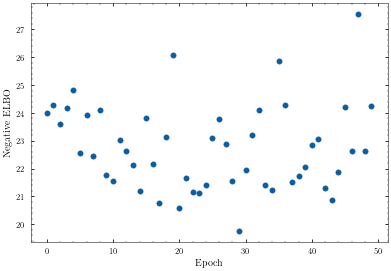

In [25]:
plot_elbo(history.history["loss"][-50:])
print(history.history['loss'][-1])
print(min(history.history['loss']))

Now that we have trained the model we can use our plotter again to visualise what we have learned.

tfp.distributions.Categorical("gp_gating_network_ExpertIndicatorCategorical", batch_shape=[100], event_shape=[], dtype=int32)
(100, 2)
<class 'tensorflow_probability.python.distributions.categorical.Categorical'>


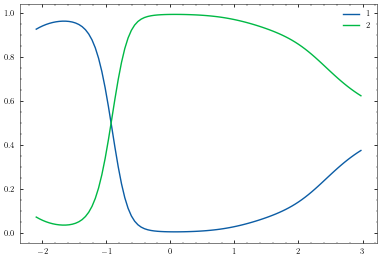

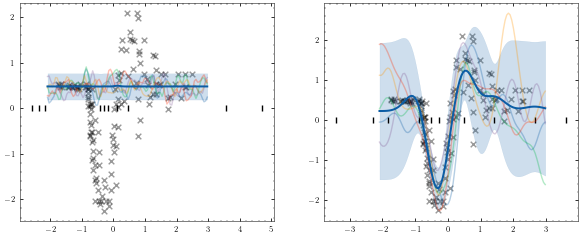

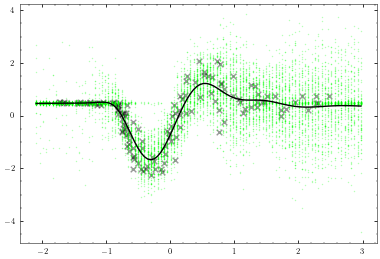

In [26]:
plotter = Plotter1D(model_from_cfg, X, Y)
plotter.plot_model()

## Three Experts
Let's now instantiate the model with three experts and three gating functions. In this setting, the gating network uses the `Softmax` likelihood to obtain the mixing probabilities.

In [27]:
num_experts = 3
num_inducing_gating = 10
num_inducing_expert = 10
experts_lengthscales = [10.0, 1.0, 10.0]  # lengthsales for expert 1 and 2
three_experts_list = [init_expert(experts_lengthscales[k]) for k in range(num_experts)]
three_gating_network = init_gating_network(num_gating_gps=num_experts)
model_three_experts = MixtureOfSVGPExperts(experts_list=three_experts_list, gating_network=three_gating_network)

Let's visualise our `MixtureOfSVGPExperts` with three experts and three gating functions.

tfp.distributions.Categorical("gp_gating_network_ExpertIndicatorCategorical", batch_shape=[100], event_shape=[], dtype=int32)
(100, 3)
<class 'tensorflow_probability.python.distributions.categorical.Categorical'>


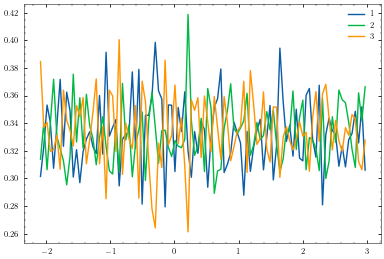

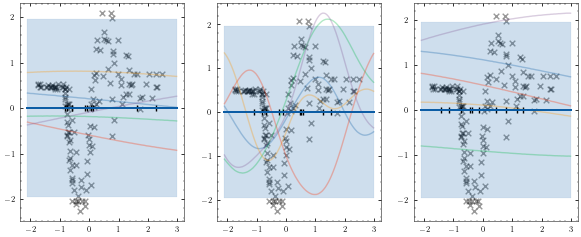

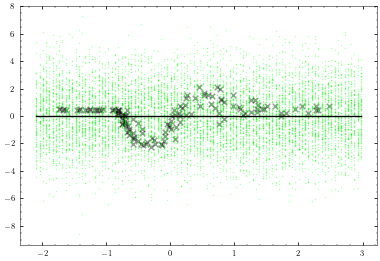

In [28]:
plotter = Plotter1D(model_three_experts, X, Y)
plotter.plot_model()

In [33]:
num_epochs = 3000
batch_size = 16
learning_rate = 0.01
num_samples = 1  # number of samples to draw from variational posterior in ELBO
ckpt_dir = "./ckpts"
log_dir = "./logs"

In [34]:
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
model_three_experts.compile(optimizer=optimizer)

We can easily use keras callbacks to monitor the model in TensorBorad and checkpoint the model during training.

In [35]:
# history = model_three_experts.fit(X, Y, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)
history = model_three_experts.fit(X, Y, epochs=num_epochs, batch_size=batch_size)

Epoch 1/3000
Mixing probs: (1, None, 3)
Y.shape
(None, 1)
(1, None, 1)
Experts probs[0]: (None, None)
Experts probs[0]: (None, None)
Experts probs[0]: (None, None)
Experts probs: (None, None, 3)
Experts probs EXP: (None, 1, None, 1, 3)
Mixing probs EXP: (1, 1, None, 3, 1)
Matmul EXP: (None, 1, None, 1, 1)
Marginalised indicator variable: (None, 1, None)
Mixing probs: (1, None, 3)
Y.shape
(None, 1)
(1, None, 1)
Experts probs[0]: (None, None)
Experts probs[0]: (None, None)
Experts probs[0]: (None, None)
Experts probs: (None, None, 3)
Experts probs EXP: (None, 1, None, 1, 3)
Mixing probs EXP: (1, 1, None, 3, 1)
Matmul EXP: (None, 1, None, 1, 1)
Marginalised indicator variable: (None, 1, None)
9/9 [==============================] - 13s 5ms/step - loss: 16.2462 - gating_kl: 3.5491 - experts_kl: 0.1253
Epoch 2/3000
9/9 [==============================] - 0s 4ms/step - loss: 15.1902 - gating_kl: 3.5492 - experts_kl: 0.1252
Epoch 3/3000
9/9 [==============================] - 0s 4ms/step - loss:

9/9 [==============================] - 0s 6ms/step - loss: 16.2407 - gating_kl: 3.5593 - experts_kl: 0.1228
Epoch 62/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.1753 - gating_kl: 3.5595 - experts_kl: 0.1228
Epoch 63/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.9928 - gating_kl: 3.5596 - experts_kl: 0.1228
Epoch 64/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.4038 - gating_kl: 3.5598 - experts_kl: 0.1227
Epoch 65/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.9777 - gating_kl: 3.5599 - experts_kl: 0.1227
Epoch 66/3000
9/9 [==============================] - 0s 6ms/step - loss: 16.5206 - gating_kl: 3.5601 - experts_kl: 0.1226
Epoch 67/3000
9/9 [==============================] - 0s 6ms/step - loss: 14.2213 - gating_kl: 3.5603 - experts_kl: 0.1226
Epoch 68/3000
9/9 [==============================] - 0s 6ms/step - loss: 16.3266 - gating_kl: 3.5604 - experts_kl: 0.1226
Epoch 69/3000
9/9 [===================

9/9 [==============================] - 0s 8ms/step - loss: 15.7497 - gating_kl: 3.5689 - experts_kl: 0.1202
Epoch 129/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.2286 - gating_kl: 3.5691 - experts_kl: 0.1202
Epoch 130/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.9994 - gating_kl: 3.5693 - experts_kl: 0.1201
Epoch 131/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.5586 - gating_kl: 3.5694 - experts_kl: 0.1201
Epoch 132/3000
9/9 [==============================] - 0s 11ms/step - loss: 14.8619 - gating_kl: 3.5696 - experts_kl: 0.1201
Epoch 133/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.5646 - gating_kl: 3.5697 - experts_kl: 0.1200
Epoch 134/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.8757 - gating_kl: 3.5698 - experts_kl: 0.1200
Epoch 135/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.5659 - gating_kl: 3.5700 - experts_kl: 0.1199
Epoch 136/3000
9/9 [==========

9/9 [==============================] - 0s 6ms/step - loss: 15.1171 - gating_kl: 3.5777 - experts_kl: 0.1177
Epoch 195/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.0074 - gating_kl: 3.5778 - experts_kl: 0.1177
Epoch 196/3000
9/9 [==============================] - 0s 6ms/step - loss: 16.1252 - gating_kl: 3.5780 - experts_kl: 0.1177
Epoch 197/3000
9/9 [==============================] - 0s 6ms/step - loss: 16.6128 - gating_kl: 3.5781 - experts_kl: 0.1176
Epoch 198/3000
9/9 [==============================] - 0s 5ms/step - loss: 15.6693 - gating_kl: 3.5783 - experts_kl: 0.1176
Epoch 199/3000
9/9 [==============================] - 0s 5ms/step - loss: 14.3631 - gating_kl: 3.5784 - experts_kl: 0.1175
Epoch 200/3000
9/9 [==============================] - 0s 5ms/step - loss: 15.6160 - gating_kl: 3.5785 - experts_kl: 0.1175
Epoch 201/3000
9/9 [==============================] - 0s 5ms/step - loss: 15.9121 - gating_kl: 3.5785 - experts_kl: 0.1175
Epoch 202/3000
9/9 [===========

9/9 [==============================] - 0s 6ms/step - loss: 16.1733 - gating_kl: 3.5883 - experts_kl: 0.1154
Epoch 261/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.9913 - gating_kl: 3.5884 - experts_kl: 0.1153
Epoch 262/3000
9/9 [==============================] - 0s 6ms/step - loss: 14.7467 - gating_kl: 3.5885 - experts_kl: 0.1153
Epoch 263/3000
9/9 [==============================] - 0s 6ms/step - loss: 16.0161 - gating_kl: 3.5886 - experts_kl: 0.1153
Epoch 264/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.9140 - gating_kl: 3.5888 - experts_kl: 0.1152
Epoch 265/3000
9/9 [==============================] - 0s 6ms/step - loss: 16.9905 - gating_kl: 3.5889 - experts_kl: 0.1152
Epoch 266/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.0558 - gating_kl: 3.5890 - experts_kl: 0.1151
Epoch 267/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.5119 - gating_kl: 3.5891 - experts_kl: 0.1151
Epoch 268/3000
9/9 [===========

9/9 [==============================] - 0s 7ms/step - loss: 15.4687 - gating_kl: 3.5992 - experts_kl: 0.1131
Epoch 327/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.8445 - gating_kl: 3.5994 - experts_kl: 0.1130
Epoch 328/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.5885 - gating_kl: 3.5996 - experts_kl: 0.1130
Epoch 329/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.8784 - gating_kl: 3.5998 - experts_kl: 0.1130
Epoch 330/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.5041 - gating_kl: 3.5999 - experts_kl: 0.1129
Epoch 331/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.9686 - gating_kl: 3.6000 - experts_kl: 0.1129
Epoch 332/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.4504 - gating_kl: 3.6001 - experts_kl: 0.1129
Epoch 333/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.9711 - gating_kl: 3.6003 - experts_kl: 0.1128
Epoch 334/3000
9/9 [===========

9/9 [==============================] - 0s 5ms/step - loss: 16.6576 - gating_kl: 3.6099 - experts_kl: 0.1109
Epoch 393/3000
9/9 [==============================] - 0s 6ms/step - loss: 16.5012 - gating_kl: 3.6102 - experts_kl: 0.1108
Epoch 394/3000
9/9 [==============================] - 0s 5ms/step - loss: 16.1921 - gating_kl: 3.6105 - experts_kl: 0.1108
Epoch 395/3000
9/9 [==============================] - 0s 6ms/step - loss: 16.4288 - gating_kl: 3.6107 - experts_kl: 0.1108
Epoch 396/3000
9/9 [==============================] - 0s 5ms/step - loss: 15.8830 - gating_kl: 3.6109 - experts_kl: 0.1107
Epoch 397/3000
9/9 [==============================] - 0s 6ms/step - loss: 16.0373 - gating_kl: 3.6111 - experts_kl: 0.1107
Epoch 398/3000
9/9 [==============================] - 0s 6ms/step - loss: 16.4773 - gating_kl: 3.6113 - experts_kl: 0.1107
Epoch 399/3000
9/9 [==============================] - 0s 5ms/step - loss: 15.8866 - gating_kl: 3.6115 - experts_kl: 0.1107
Epoch 400/3000
9/9 [===========

9/9 [==============================] - 0s 7ms/step - loss: 15.6076 - gating_kl: 3.6196 - experts_kl: 0.1088
Epoch 459/3000
9/9 [==============================] - 0s 7ms/step - loss: 14.4607 - gating_kl: 3.6197 - experts_kl: 0.1087
Epoch 460/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.8501 - gating_kl: 3.6198 - experts_kl: 0.1087
Epoch 461/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.7783 - gating_kl: 3.6199 - experts_kl: 0.1087
Epoch 462/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.6831 - gating_kl: 3.6200 - experts_kl: 0.1086
Epoch 463/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.0670 - gating_kl: 3.6201 - experts_kl: 0.1086
Epoch 464/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.8199 - gating_kl: 3.6203 - experts_kl: 0.1086
Epoch 465/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.4133 - gating_kl: 3.6205 - experts_kl: 0.1086
Epoch 466/3000
9/9 [===========

9/9 [==============================] - 0s 6ms/step - loss: 16.7519 - gating_kl: 3.6295 - experts_kl: 0.1067
Epoch 525/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.1028 - gating_kl: 3.6296 - experts_kl: 0.1067
Epoch 526/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.9692 - gating_kl: 3.6297 - experts_kl: 0.1067
Epoch 527/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.1716 - gating_kl: 3.6298 - experts_kl: 0.1067
Epoch 528/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.6841 - gating_kl: 3.6299 - experts_kl: 0.1066
Epoch 529/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.4674 - gating_kl: 3.6300 - experts_kl: 0.1066
Epoch 530/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.1892 - gating_kl: 3.6301 - experts_kl: 0.1066
Epoch 531/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.1410 - gating_kl: 3.6302 - experts_kl: 0.1065
Epoch 532/3000
9/9 [===========

9/9 [==============================] - 0s 6ms/step - loss: 15.6962 - gating_kl: 3.6363 - experts_kl: 0.1048
Epoch 591/3000
9/9 [==============================] - 0s 6ms/step - loss: 14.9936 - gating_kl: 3.6364 - experts_kl: 0.1048
Epoch 592/3000
9/9 [==============================] - 0s 14ms/step - loss: 15.8434 - gating_kl: 3.6365 - experts_kl: 0.1047
Epoch 593/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.5720 - gating_kl: 3.6366 - experts_kl: 0.1047
Epoch 594/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.8815 - gating_kl: 3.6366 - experts_kl: 0.1047
Epoch 595/3000
9/9 [==============================] - 0s 6ms/step - loss: 17.0101 - gating_kl: 3.6367 - experts_kl: 0.1046
Epoch 596/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.0334 - gating_kl: 3.6367 - experts_kl: 0.1046
Epoch 597/3000
9/9 [==============================] - 0s 6ms/step - loss: 17.1193 - gating_kl: 3.6368 - experts_kl: 0.1046
Epoch 598/3000
9/9 [==========

9/9 [==============================] - 0s 9ms/step - loss: 15.5001 - gating_kl: 3.6441 - experts_kl: 0.1029
Epoch 657/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.5853 - gating_kl: 3.6442 - experts_kl: 0.1029
Epoch 658/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.1371 - gating_kl: 3.6443 - experts_kl: 0.1029
Epoch 659/3000
9/9 [==============================] - 0s 10ms/step - loss: 16.8637 - gating_kl: 3.6443 - experts_kl: 0.1028
Epoch 660/3000
9/9 [==============================] - 0s 9ms/step - loss: 14.2675 - gating_kl: 3.6443 - experts_kl: 0.1028
Epoch 661/3000
9/9 [==============================] - 0s 9ms/step - loss: 16.2120 - gating_kl: 3.6444 - experts_kl: 0.1028
Epoch 662/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.1653 - gating_kl: 3.6444 - experts_kl: 0.1027
Epoch 663/3000
9/9 [==============================] - 0s 9ms/step - loss: 14.2072 - gating_kl: 3.6445 - experts_kl: 0.1027
Epoch 664/3000
9/9 [==========

9/9 [==============================] - 0s 9ms/step - loss: 16.2400 - gating_kl: 3.6524 - experts_kl: 0.1011
Epoch 723/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.2497 - gating_kl: 3.6526 - experts_kl: 0.1011
Epoch 724/3000
9/9 [==============================] - 0s 9ms/step - loss: 16.3148 - gating_kl: 3.6528 - experts_kl: 0.1010
Epoch 725/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.3238 - gating_kl: 3.6529 - experts_kl: 0.1010
Epoch 726/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.8145 - gating_kl: 3.6530 - experts_kl: 0.1010
Epoch 727/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.5342 - gating_kl: 3.6532 - experts_kl: 0.1010
Epoch 728/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.6696 - gating_kl: 3.6533 - experts_kl: 0.1009
Epoch 729/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.2642 - gating_kl: 3.6535 - experts_kl: 0.1009
Epoch 730/3000
9/9 [===========

9/9 [==============================] - 0s 9ms/step - loss: 16.0089 - gating_kl: 3.6608 - experts_kl: 0.0993
Epoch 789/3000
9/9 [==============================] - 0s 9ms/step - loss: 16.2768 - gating_kl: 3.6609 - experts_kl: 0.0993
Epoch 790/3000
9/9 [==============================] - 0s 10ms/step - loss: 15.1891 - gating_kl: 3.6611 - experts_kl: 0.0993
Epoch 791/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.3232 - gating_kl: 3.6612 - experts_kl: 0.0993
Epoch 792/3000
9/9 [==============================] - 0s 11ms/step - loss: 15.2654 - gating_kl: 3.6613 - experts_kl: 0.0992
Epoch 793/3000
9/9 [==============================] - 0s 10ms/step - loss: 16.2731 - gating_kl: 3.6614 - experts_kl: 0.0992
Epoch 794/3000
9/9 [==============================] - 0s 12ms/step - loss: 17.6661 - gating_kl: 3.6615 - experts_kl: 0.0992
Epoch 795/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.7214 - gating_kl: 3.6616 - experts_kl: 0.0992
Epoch 796/3000
9/9 [=======

9/9 [==============================] - 0s 10ms/step - loss: 16.7073 - gating_kl: 3.6703 - experts_kl: 0.0976
Epoch 855/3000
9/9 [==============================] - 0s 9ms/step - loss: 17.4951 - gating_kl: 3.6705 - experts_kl: 0.0976
Epoch 856/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.7871 - gating_kl: 3.6707 - experts_kl: 0.0976
Epoch 857/3000
9/9 [==============================] - 0s 9ms/step - loss: 14.9536 - gating_kl: 3.6709 - experts_kl: 0.0976
Epoch 858/3000
9/9 [==============================] - 0s 9ms/step - loss: 16.4439 - gating_kl: 3.6710 - experts_kl: 0.0975
Epoch 859/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.7327 - gating_kl: 3.6712 - experts_kl: 0.0975
Epoch 860/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.7219 - gating_kl: 3.6713 - experts_kl: 0.0975
Epoch 861/3000
9/9 [==============================] - 0s 9ms/step - loss: 16.0427 - gating_kl: 3.6715 - experts_kl: 0.0975
Epoch 862/3000
9/9 [==========

9/9 [==============================] - 0s 18ms/step - loss: 15.9564 - gating_kl: 3.6792 - experts_kl: 0.0960
Epoch 921/3000
9/9 [==============================] - 0s 14ms/step - loss: 16.1758 - gating_kl: 3.6793 - experts_kl: 0.0960
Epoch 922/3000
9/9 [==============================] - 0s 12ms/step - loss: 15.8911 - gating_kl: 3.6795 - experts_kl: 0.0960
Epoch 923/3000
9/9 [==============================] - 0s 19ms/step - loss: 15.9411 - gating_kl: 3.6796 - experts_kl: 0.0959
Epoch 924/3000
9/9 [==============================] - 0s 15ms/step - loss: 15.7023 - gating_kl: 3.6797 - experts_kl: 0.0959
Epoch 925/3000
9/9 [==============================] - 0s 12ms/step - loss: 16.2444 - gating_kl: 3.6799 - experts_kl: 0.0959
Epoch 926/3000
9/9 [==============================] - 0s 13ms/step - loss: 15.7128 - gating_kl: 3.6800 - experts_kl: 0.0959
Epoch 927/3000
9/9 [==============================] - 0s 16ms/step - loss: 15.9783 - gating_kl: 3.6801 - experts_kl: 0.0958
Epoch 928/3000
9/9 [===

9/9 [==============================] - 0s 9ms/step - loss: 15.8517 - gating_kl: 3.6866 - experts_kl: 0.0944
Epoch 987/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.7237 - gating_kl: 3.6867 - experts_kl: 0.0944
Epoch 988/3000
9/9 [==============================] - 0s 9ms/step - loss: 16.0811 - gating_kl: 3.6868 - experts_kl: 0.0944
Epoch 989/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.1084 - gating_kl: 3.6870 - experts_kl: 0.0944
Epoch 990/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.4221 - gating_kl: 3.6871 - experts_kl: 0.0943
Epoch 991/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.0233 - gating_kl: 3.6872 - experts_kl: 0.0943
Epoch 992/3000
9/9 [==============================] - 0s 9ms/step - loss: 16.6051 - gating_kl: 3.6872 - experts_kl: 0.0943
Epoch 993/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.6505 - gating_kl: 3.6873 - experts_kl: 0.0943
Epoch 994/3000
9/9 [===========

9/9 [==============================] - 0s 8ms/step - loss: 15.7619 - gating_kl: 3.6942 - experts_kl: 0.0929
Epoch 1053/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.2078 - gating_kl: 3.6943 - experts_kl: 0.0929
Epoch 1054/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.7849 - gating_kl: 3.6945 - experts_kl: 0.0928
Epoch 1055/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.5733 - gating_kl: 3.6946 - experts_kl: 0.0928
Epoch 1056/3000
9/9 [==============================] - 0s 8ms/step - loss: 14.7425 - gating_kl: 3.6946 - experts_kl: 0.0928
Epoch 1057/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.7531 - gating_kl: 3.6947 - experts_kl: 0.0928
Epoch 1058/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.4388 - gating_kl: 3.6947 - experts_kl: 0.0927
Epoch 1059/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.7506 - gating_kl: 3.6948 - experts_kl: 0.0927
Epoch 1060/3000
9/9 [===

9/9 [==============================] - 0s 8ms/step - loss: 15.3150 - gating_kl: 3.7015 - experts_kl: 0.0914
Epoch 1119/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.7695 - gating_kl: 3.7015 - experts_kl: 0.0914
Epoch 1120/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.2478 - gating_kl: 3.7016 - experts_kl: 0.0914
Epoch 1121/3000
9/9 [==============================] - 0s 10ms/step - loss: 15.9614 - gating_kl: 3.7018 - experts_kl: 0.0913
Epoch 1122/3000
9/9 [==============================] - 0s 10ms/step - loss: 16.1457 - gating_kl: 3.7020 - experts_kl: 0.0913
Epoch 1123/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.4797 - gating_kl: 3.7021 - experts_kl: 0.0913
Epoch 1124/3000
9/9 [==============================] - 0s 8ms/step - loss: 14.6528 - gating_kl: 3.7022 - experts_kl: 0.0913
Epoch 1125/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.7973 - gating_kl: 3.7023 - experts_kl: 0.0912
Epoch 1126/3000
9/9 [=

9/9 [==============================] - 0s 8ms/step - loss: 16.0487 - gating_kl: 3.7098 - experts_kl: 0.0900
Epoch 1185/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.9514 - gating_kl: 3.7099 - experts_kl: 0.0899
Epoch 1186/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.1683 - gating_kl: 3.7101 - experts_kl: 0.0899
Epoch 1187/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.4266 - gating_kl: 3.7102 - experts_kl: 0.0899
Epoch 1188/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.1326 - gating_kl: 3.7104 - experts_kl: 0.0899
Epoch 1189/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.7653 - gating_kl: 3.7105 - experts_kl: 0.0899
Epoch 1190/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.7559 - gating_kl: 3.7106 - experts_kl: 0.0898
Epoch 1191/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.2454 - gating_kl: 3.7107 - experts_kl: 0.0898
Epoch 1192/3000
9/9 [===

9/9 [==============================] - 0s 7ms/step - loss: 15.2532 - gating_kl: 3.7168 - experts_kl: 0.0886
Epoch 1251/3000
9/9 [==============================] - 0s 7ms/step - loss: 14.9578 - gating_kl: 3.7167 - experts_kl: 0.0885
Epoch 1252/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.3989 - gating_kl: 3.7167 - experts_kl: 0.0885
Epoch 1253/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.0303 - gating_kl: 3.7167 - experts_kl: 0.0885
Epoch 1254/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.3923 - gating_kl: 3.7167 - experts_kl: 0.0885
Epoch 1255/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.4645 - gating_kl: 3.7168 - experts_kl: 0.0885
Epoch 1256/3000
9/9 [==============================] - 0s 7ms/step - loss: 14.8610 - gating_kl: 3.7168 - experts_kl: 0.0884
Epoch 1257/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.3844 - gating_kl: 3.7169 - experts_kl: 0.0884
Epoch 1258/3000
9/9 [===

9/9 [==============================] - 0s 9ms/step - loss: 15.7208 - gating_kl: 3.7235 - experts_kl: 0.0872
Epoch 1317/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.7302 - gating_kl: 3.7236 - experts_kl: 0.0872
Epoch 1318/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.7710 - gating_kl: 3.7236 - experts_kl: 0.0872
Epoch 1319/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.2151 - gating_kl: 3.7237 - experts_kl: 0.0872
Epoch 1320/3000
9/9 [==============================] - 0s 9ms/step - loss: 16.9004 - gating_kl: 3.7238 - experts_kl: 0.0871
Epoch 1321/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.4738 - gating_kl: 3.7239 - experts_kl: 0.0871
Epoch 1322/3000
9/9 [==============================] - 0s 9ms/step - loss: 16.7643 - gating_kl: 3.7241 - experts_kl: 0.0871
Epoch 1323/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.6166 - gating_kl: 3.7242 - experts_kl: 0.0871
Epoch 1324/3000
9/9 [===

9/9 [==============================] - 0s 8ms/step - loss: 15.1307 - gating_kl: 3.7299 - experts_kl: 0.0859
Epoch 1383/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.7436 - gating_kl: 3.7300 - experts_kl: 0.0859
Epoch 1384/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.7460 - gating_kl: 3.7301 - experts_kl: 0.0859
Epoch 1385/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.1289 - gating_kl: 3.7303 - experts_kl: 0.0858
Epoch 1386/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.6390 - gating_kl: 3.7304 - experts_kl: 0.0858
Epoch 1387/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.8951 - gating_kl: 3.7304 - experts_kl: 0.0858
Epoch 1388/3000
9/9 [==============================] - 0s 8ms/step - loss: 14.8928 - gating_kl: 3.7305 - experts_kl: 0.0858
Epoch 1389/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.0536 - gating_kl: 3.7305 - experts_kl: 0.0858
Epoch 1390/3000
9/9 [===

9/9 [==============================] - 0s 10ms/step - loss: 16.2338 - gating_kl: 3.7359 - experts_kl: 0.0846
Epoch 1449/3000
9/9 [==============================] - 0s 10ms/step - loss: 16.2522 - gating_kl: 3.7361 - experts_kl: 0.0846
Epoch 1450/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.5671 - gating_kl: 3.7363 - experts_kl: 0.0846
Epoch 1451/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.8439 - gating_kl: 3.7364 - experts_kl: 0.0846
Epoch 1452/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.7784 - gating_kl: 3.7365 - experts_kl: 0.0846
Epoch 1453/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.6458 - gating_kl: 3.7366 - experts_kl: 0.0845
Epoch 1454/3000
9/9 [==============================] - 0s 7ms/step - loss: 17.4843 - gating_kl: 3.7366 - experts_kl: 0.0845
Epoch 1455/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.6303 - gating_kl: 3.7367 - experts_kl: 0.0845
Epoch 1456/3000
9/9 [=

9/9 [==============================] - 0s 7ms/step - loss: 16.6407 - gating_kl: 3.7425 - experts_kl: 0.0834
Epoch 1515/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.0749 - gating_kl: 3.7426 - experts_kl: 0.0834
Epoch 1516/3000
9/9 [==============================] - 0s 6ms/step - loss: 16.2820 - gating_kl: 3.7428 - experts_kl: 0.0834
Epoch 1517/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.5801 - gating_kl: 3.7429 - experts_kl: 0.0833
Epoch 1518/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.7236 - gating_kl: 3.7430 - experts_kl: 0.0833
Epoch 1519/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.4738 - gating_kl: 3.7431 - experts_kl: 0.0833
Epoch 1520/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.0567 - gating_kl: 3.7432 - experts_kl: 0.0833
Epoch 1521/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.2322 - gating_kl: 3.7433 - experts_kl: 0.0833
Epoch 1522/3000
9/9 [===

9/9 [==============================] - 0s 12ms/step - loss: 15.5803 - gating_kl: 3.7485 - experts_kl: 0.0822
Epoch 1581/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.2178 - gating_kl: 3.7486 - experts_kl: 0.0822
Epoch 1582/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.5497 - gating_kl: 3.7488 - experts_kl: 0.0822
Epoch 1583/3000
9/9 [==============================] - 0s 7ms/step - loss: 14.9609 - gating_kl: 3.7489 - experts_kl: 0.0821
Epoch 1584/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.7119 - gating_kl: 3.7490 - experts_kl: 0.0821
Epoch 1585/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.4569 - gating_kl: 3.7491 - experts_kl: 0.0821
Epoch 1586/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.3406 - gating_kl: 3.7492 - experts_kl: 0.0821
Epoch 1587/3000
9/9 [==============================] - 0s 7ms/step - loss: 17.0488 - gating_kl: 3.7493 - experts_kl: 0.0821
Epoch 1588/3000
9/9 [==

9/9 [==============================] - 0s 7ms/step - loss: 16.7410 - gating_kl: 3.7562 - experts_kl: 0.0810
Epoch 1647/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.1270 - gating_kl: 3.7563 - experts_kl: 0.0810
Epoch 1648/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.3621 - gating_kl: 3.7565 - experts_kl: 0.0810
Epoch 1649/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.3998 - gating_kl: 3.7566 - experts_kl: 0.0810
Epoch 1650/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.0486 - gating_kl: 3.7567 - experts_kl: 0.0810
Epoch 1651/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.4047 - gating_kl: 3.7568 - experts_kl: 0.0809
Epoch 1652/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.8813 - gating_kl: 3.7569 - experts_kl: 0.0809
Epoch 1653/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.1545 - gating_kl: 3.7570 - experts_kl: 0.0809
Epoch 1654/3000
9/9 [===

9/9 [==============================] - 0s 6ms/step - loss: 16.2336 - gating_kl: 3.7609 - experts_kl: 0.0799
Epoch 1713/3000
9/9 [==============================] - 0s 6ms/step - loss: 16.4633 - gating_kl: 3.7610 - experts_kl: 0.0799
Epoch 1714/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.7098 - gating_kl: 3.7611 - experts_kl: 0.0799
Epoch 1715/3000
9/9 [==============================] - 0s 6ms/step - loss: 16.2318 - gating_kl: 3.7613 - experts_kl: 0.0798
Epoch 1716/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.9465 - gating_kl: 3.7614 - experts_kl: 0.0798
Epoch 1717/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.8552 - gating_kl: 3.7615 - experts_kl: 0.0798
Epoch 1718/3000
9/9 [==============================] - 0s 6ms/step - loss: 16.5253 - gating_kl: 3.7616 - experts_kl: 0.0798
Epoch 1719/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.9254 - gating_kl: 3.7616 - experts_kl: 0.0798
Epoch 1720/3000
9/9 [===

9/9 [==============================] - 0s 6ms/step - loss: 16.6011 - gating_kl: 3.7673 - experts_kl: 0.0788
Epoch 1779/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.2961 - gating_kl: 3.7674 - experts_kl: 0.0788
Epoch 1780/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.6072 - gating_kl: 3.7675 - experts_kl: 0.0788
Epoch 1781/3000
9/9 [==============================] - 0s 6ms/step - loss: 14.9986 - gating_kl: 3.7676 - experts_kl: 0.0787
Epoch 1782/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.1118 - gating_kl: 3.7676 - experts_kl: 0.0787
Epoch 1783/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.0870 - gating_kl: 3.7677 - experts_kl: 0.0787
Epoch 1784/3000
9/9 [==============================] - 0s 6ms/step - loss: 17.1797 - gating_kl: 3.7677 - experts_kl: 0.0787
Epoch 1785/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.2569 - gating_kl: 3.7679 - experts_kl: 0.0787
Epoch 1786/3000
9/9 [===

9/9 [==============================] - 0s 6ms/step - loss: 16.0277 - gating_kl: 3.7722 - experts_kl: 0.0777
Epoch 1845/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.3275 - gating_kl: 3.7723 - experts_kl: 0.0777
Epoch 1846/3000
9/9 [==============================] - 0s 6ms/step - loss: 16.2779 - gating_kl: 3.7724 - experts_kl: 0.0777
Epoch 1847/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.1216 - gating_kl: 3.7725 - experts_kl: 0.0777
Epoch 1848/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.5395 - gating_kl: 3.7725 - experts_kl: 0.0777
Epoch 1849/3000
9/9 [==============================] - 0s 7ms/step - loss: 14.8934 - gating_kl: 3.7726 - experts_kl: 0.0776
Epoch 1850/3000
9/9 [==============================] - 0s 6ms/step - loss: 16.9410 - gating_kl: 3.7726 - experts_kl: 0.0776
Epoch 1851/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.7440 - gating_kl: 3.7727 - experts_kl: 0.0776
Epoch 1852/3000
9/9 [===

9/9 [==============================] - 0s 7ms/step - loss: 15.2968 - gating_kl: 3.7766 - experts_kl: 0.0767
Epoch 1911/3000
9/9 [==============================] - 0s 9ms/step - loss: 14.9319 - gating_kl: 3.7766 - experts_kl: 0.0767
Epoch 1912/3000
9/9 [==============================] - 0s 9ms/step - loss: 16.3075 - gating_kl: 3.7766 - experts_kl: 0.0766
Epoch 1913/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.6566 - gating_kl: 3.7766 - experts_kl: 0.0766
Epoch 1914/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.6278 - gating_kl: 3.7766 - experts_kl: 0.0766
Epoch 1915/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.2958 - gating_kl: 3.7767 - experts_kl: 0.0766
Epoch 1916/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.1164 - gating_kl: 3.7768 - experts_kl: 0.0766
Epoch 1917/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.5000 - gating_kl: 3.7768 - experts_kl: 0.0766
Epoch 1918/3000
9/9 [===

9/9 [==============================] - 0s 7ms/step - loss: 15.2417 - gating_kl: 3.7827 - experts_kl: 0.0757
Epoch 1977/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.6664 - gating_kl: 3.7828 - experts_kl: 0.0756
Epoch 1978/3000
9/9 [==============================] - 0s 8ms/step - loss: 14.8180 - gating_kl: 3.7829 - experts_kl: 0.0756
Epoch 1979/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.1908 - gating_kl: 3.7830 - experts_kl: 0.0756
Epoch 1980/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.9221 - gating_kl: 3.7831 - experts_kl: 0.0756
Epoch 1981/3000
9/9 [==============================] - 0s 9ms/step - loss: 16.4851 - gating_kl: 3.7831 - experts_kl: 0.0756
Epoch 1982/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.6931 - gating_kl: 3.7832 - experts_kl: 0.0756
Epoch 1983/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.9556 - gating_kl: 3.7833 - experts_kl: 0.0756
Epoch 1984/3000
9/9 [===

9/9 [==============================] - 0s 8ms/step - loss: 16.1166 - gating_kl: 3.7874 - experts_kl: 0.0747
Epoch 2043/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.8185 - gating_kl: 3.7875 - experts_kl: 0.0747
Epoch 2044/3000
9/9 [==============================] - 0s 10ms/step - loss: 16.6573 - gating_kl: 3.7876 - experts_kl: 0.0746
Epoch 2045/3000
9/9 [==============================] - 0s 25ms/step - loss: 15.8113 - gating_kl: 3.7877 - experts_kl: 0.0746
Epoch 2046/3000
9/9 [==============================] - 0s 17ms/step - loss: 16.8836 - gating_kl: 3.7878 - experts_kl: 0.0746
Epoch 2047/3000
9/9 [==============================] - 0s 11ms/step - loss: 15.5212 - gating_kl: 3.7879 - experts_kl: 0.0746
Epoch 2048/3000
9/9 [==============================] - 0s 11ms/step - loss: 15.1196 - gating_kl: 3.7880 - experts_kl: 0.0746
Epoch 2049/3000
9/9 [==============================] - 0s 11ms/step - loss: 15.0316 - gating_kl: 3.7880 - experts_kl: 0.0746
Epoch 2050/3000
9/

Epoch 2108/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.4652 - gating_kl: 3.7925 - experts_kl: 0.0737
Epoch 2109/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.6665 - gating_kl: 3.7925 - experts_kl: 0.0737
Epoch 2110/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.8729 - gating_kl: 3.7926 - experts_kl: 0.0737
Epoch 2111/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.6325 - gating_kl: 3.7926 - experts_kl: 0.0737
Epoch 2112/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.0366 - gating_kl: 3.7927 - experts_kl: 0.0736
Epoch 2113/3000
9/9 [==============================] - 0s 8ms/step - loss: 14.7585 - gating_kl: 3.7927 - experts_kl: 0.0736
Epoch 2114/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.1199 - gating_kl: 3.7927 - experts_kl: 0.0736
Epoch 2115/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.9383 - gating_kl: 3.7928 - experts_kl: 0.0736
Epoch 21

9/9 [==============================] - 0s 7ms/step - loss: 15.3267 - gating_kl: 3.7968 - experts_kl: 0.0728
Epoch 2175/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.2300 - gating_kl: 3.7969 - experts_kl: 0.0728
Epoch 2176/3000
9/9 [==============================] - 0s 10ms/step - loss: 15.8574 - gating_kl: 3.7970 - experts_kl: 0.0727
Epoch 2177/3000
9/9 [==============================] - 0s 10ms/step - loss: 17.1965 - gating_kl: 3.7970 - experts_kl: 0.0727
Epoch 2178/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.8955 - gating_kl: 3.7971 - experts_kl: 0.0727
Epoch 2179/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.7562 - gating_kl: 3.7973 - experts_kl: 0.0727
Epoch 2180/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.4261 - gating_kl: 3.7974 - experts_kl: 0.0727
Epoch 2181/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.8057 - gating_kl: 3.7975 - experts_kl: 0.0727
Epoch 2182/3000
9/9 [=

9/9 [==============================] - 0s 8ms/step - loss: 17.6057 - gating_kl: 3.8014 - experts_kl: 0.0718
Epoch 2241/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.2872 - gating_kl: 3.8015 - experts_kl: 0.0718
Epoch 2242/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.4022 - gating_kl: 3.8016 - experts_kl: 0.0718
Epoch 2243/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.2965 - gating_kl: 3.8017 - experts_kl: 0.0718
Epoch 2244/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.2784 - gating_kl: 3.8018 - experts_kl: 0.0718
Epoch 2245/3000
9/9 [==============================] - 0s 8ms/step - loss: 14.8989 - gating_kl: 3.8018 - experts_kl: 0.0718
Epoch 2246/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.6957 - gating_kl: 3.8019 - experts_kl: 0.0718
Epoch 2247/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.5451 - gating_kl: 3.8019 - experts_kl: 0.0718
Epoch 2248/3000
9/9 [===

9/9 [==============================] - 0s 9ms/step - loss: 15.2626 - gating_kl: 3.8060 - experts_kl: 0.0710
Epoch 2307/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.5736 - gating_kl: 3.8060 - experts_kl: 0.0709
Epoch 2308/3000
9/9 [==============================] - 0s 10ms/step - loss: 15.7396 - gating_kl: 3.8060 - experts_kl: 0.0709
Epoch 2309/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.5961 - gating_kl: 3.8060 - experts_kl: 0.0709
Epoch 2310/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.6665 - gating_kl: 3.8061 - experts_kl: 0.0709
Epoch 2311/3000
9/9 [==============================] - 0s 9ms/step - loss: 14.9270 - gating_kl: 3.8061 - experts_kl: 0.0709
Epoch 2312/3000
9/9 [==============================] - 0s 10ms/step - loss: 15.7818 - gating_kl: 3.8061 - experts_kl: 0.0709
Epoch 2313/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.6080 - gating_kl: 3.8062 - experts_kl: 0.0709
Epoch 2314/3000
9/9 [=

9/9 [==============================] - 0s 7ms/step - loss: 16.0521 - gating_kl: 3.8112 - experts_kl: 0.0701
Epoch 2373/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.4295 - gating_kl: 3.8113 - experts_kl: 0.0701
Epoch 2374/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.1258 - gating_kl: 3.8114 - experts_kl: 0.0701
Epoch 2375/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.2910 - gating_kl: 3.8114 - experts_kl: 0.0700
Epoch 2376/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.5655 - gating_kl: 3.8115 - experts_kl: 0.0700
Epoch 2377/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.1323 - gating_kl: 3.8116 - experts_kl: 0.0700
Epoch 2378/3000
9/9 [==============================] - 0s 7ms/step - loss: 17.4177 - gating_kl: 3.8116 - experts_kl: 0.0700
Epoch 2379/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.8487 - gating_kl: 3.8117 - experts_kl: 0.0700
Epoch 2380/3000
9/9 [===

9/9 [==============================] - 0s 9ms/step - loss: 16.6959 - gating_kl: 3.8160 - experts_kl: 0.0692
Epoch 2439/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.8100 - gating_kl: 3.8160 - experts_kl: 0.0692
Epoch 2440/3000
9/9 [==============================] - 0s 8ms/step - loss: 17.5147 - gating_kl: 3.8161 - experts_kl: 0.0692
Epoch 2441/3000
9/9 [==============================] - 0s 7ms/step - loss: 17.1496 - gating_kl: 3.8162 - experts_kl: 0.0692
Epoch 2442/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.9418 - gating_kl: 3.8163 - experts_kl: 0.0692
Epoch 2443/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.0295 - gating_kl: 3.8165 - experts_kl: 0.0692
Epoch 2444/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.7470 - gating_kl: 3.8166 - experts_kl: 0.0692
Epoch 2445/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.0140 - gating_kl: 3.8166 - experts_kl: 0.0691
Epoch 2446/3000
9/9 [===

9/9 [==============================] - 0s 8ms/step - loss: 15.3799 - gating_kl: 3.8202 - experts_kl: 0.0684
Epoch 2505/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.4924 - gating_kl: 3.8203 - experts_kl: 0.0684
Epoch 2506/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.2543 - gating_kl: 3.8204 - experts_kl: 0.0684
Epoch 2507/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.4795 - gating_kl: 3.8204 - experts_kl: 0.0684
Epoch 2508/3000
9/9 [==============================] - 0s 8ms/step - loss: 17.2351 - gating_kl: 3.8205 - experts_kl: 0.0684
Epoch 2509/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.1499 - gating_kl: 3.8206 - experts_kl: 0.0683
Epoch 2510/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.7366 - gating_kl: 3.8207 - experts_kl: 0.0683
Epoch 2511/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.9246 - gating_kl: 3.8208 - experts_kl: 0.0683
Epoch 2512/3000
9/9 [===

9/9 [==============================] - 0s 7ms/step - loss: 15.6616 - gating_kl: 3.8250 - experts_kl: 0.0676
Epoch 2571/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.3955 - gating_kl: 3.8250 - experts_kl: 0.0676
Epoch 2572/3000
9/9 [==============================] - 0s 6ms/step - loss: 14.6657 - gating_kl: 3.8250 - experts_kl: 0.0676
Epoch 2573/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.7291 - gating_kl: 3.8250 - experts_kl: 0.0676
Epoch 2574/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.4999 - gating_kl: 3.8250 - experts_kl: 0.0675
Epoch 2575/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.9852 - gating_kl: 3.8251 - experts_kl: 0.0675
Epoch 2576/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.0255 - gating_kl: 3.8251 - experts_kl: 0.0675
Epoch 2577/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.9399 - gating_kl: 3.8251 - experts_kl: 0.0675
Epoch 2578/3000
9/9 [===

9/9 [==============================] - 0s 7ms/step - loss: 16.2596 - gating_kl: 3.8297 - experts_kl: 0.0668
Epoch 2637/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.2488 - gating_kl: 3.8298 - experts_kl: 0.0668
Epoch 2638/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.5046 - gating_kl: 3.8298 - experts_kl: 0.0668
Epoch 2639/3000
9/9 [==============================] - 0s 6ms/step - loss: 16.3264 - gating_kl: 3.8298 - experts_kl: 0.0668
Epoch 2640/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.4835 - gating_kl: 3.8299 - experts_kl: 0.0668
Epoch 2641/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.1173 - gating_kl: 3.8300 - experts_kl: 0.0667
Epoch 2642/3000
9/9 [==============================] - 0s 6ms/step - loss: 14.8662 - gating_kl: 3.8300 - experts_kl: 0.0667
Epoch 2643/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.2373 - gating_kl: 3.8301 - experts_kl: 0.0667
Epoch 2644/3000
9/9 [===

9/9 [==============================] - 0s 9ms/step - loss: 15.2552 - gating_kl: 3.8347 - experts_kl: 0.0660
Epoch 2703/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.6615 - gating_kl: 3.8347 - experts_kl: 0.0660
Epoch 2704/3000
9/9 [==============================] - 0s 10ms/step - loss: 15.2185 - gating_kl: 3.8348 - experts_kl: 0.0660
Epoch 2705/3000
9/9 [==============================] - 0s 10ms/step - loss: 17.3161 - gating_kl: 3.8348 - experts_kl: 0.0660
Epoch 2706/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.3208 - gating_kl: 3.8349 - experts_kl: 0.0660
Epoch 2707/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.0369 - gating_kl: 3.8350 - experts_kl: 0.0660
Epoch 2708/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.8174 - gating_kl: 3.8351 - experts_kl: 0.0660
Epoch 2709/3000
9/9 [==============================] - 0s 9ms/step - loss: 14.9698 - gating_kl: 3.8351 - experts_kl: 0.0660
Epoch 2710/3000
9/9 [=

9/9 [==============================] - 0s 7ms/step - loss: 15.7540 - gating_kl: 3.8400 - experts_kl: 0.0653
Epoch 2769/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.2645 - gating_kl: 3.8401 - experts_kl: 0.0653
Epoch 2770/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.0972 - gating_kl: 3.8401 - experts_kl: 0.0653
Epoch 2771/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.5881 - gating_kl: 3.8402 - experts_kl: 0.0652
Epoch 2772/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.3536 - gating_kl: 3.8402 - experts_kl: 0.0652
Epoch 2773/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.9732 - gating_kl: 3.8403 - experts_kl: 0.0652
Epoch 2774/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.6465 - gating_kl: 3.8404 - experts_kl: 0.0652
Epoch 2775/3000
9/9 [==============================] - 0s 7ms/step - loss: 17.2640 - gating_kl: 3.8405 - experts_kl: 0.0652
Epoch 2776/3000
9/9 [===

9/9 [==============================] - 0s 8ms/step - loss: 14.8482 - gating_kl: 3.8438 - experts_kl: 0.0646
Epoch 2834/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.4137 - gating_kl: 3.8439 - experts_kl: 0.0645
Epoch 2835/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.3828 - gating_kl: 3.8440 - experts_kl: 0.0645
Epoch 2836/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.9839 - gating_kl: 3.8440 - experts_kl: 0.0645
Epoch 2837/3000
9/9 [==============================] - 0s 8ms/step - loss: 17.3394 - gating_kl: 3.8441 - experts_kl: 0.0645
Epoch 2838/3000
9/9 [==============================] - 0s 8ms/step - loss: 16.3381 - gating_kl: 3.8441 - experts_kl: 0.0645
Epoch 2839/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.5843 - gating_kl: 3.8443 - experts_kl: 0.0645
Epoch 2840/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.7282 - gating_kl: 3.8444 - experts_kl: 0.0645
Epoch 2841/3000
9/9 [===

9/9 [==============================] - 0s 8ms/step - loss: 15.7550 - gating_kl: 3.8483 - experts_kl: 0.0638
Epoch 2900/3000
9/9 [==============================] - 0s 9ms/step - loss: 15.3604 - gating_kl: 3.8484 - experts_kl: 0.0638
Epoch 2901/3000
9/9 [==============================] - 0s 9ms/step - loss: 16.5597 - gating_kl: 3.8485 - experts_kl: 0.0638
Epoch 2902/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.7077 - gating_kl: 3.8485 - experts_kl: 0.0638
Epoch 2903/3000
9/9 [==============================] - 0s 7ms/step - loss: 16.6481 - gating_kl: 3.8486 - experts_kl: 0.0638
Epoch 2904/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.3310 - gating_kl: 3.8487 - experts_kl: 0.0638
Epoch 2905/3000
9/9 [==============================] - 0s 8ms/step - loss: 17.0124 - gating_kl: 3.8488 - experts_kl: 0.0638
Epoch 2906/3000
9/9 [==============================] - 0s 8ms/step - loss: 15.4848 - gating_kl: 3.8489 - experts_kl: 0.0638
Epoch 2907/3000
9/9 [===

9/9 [==============================] - 0s 7ms/step - loss: 15.3103 - gating_kl: 3.8521 - experts_kl: 0.0631
Epoch 2966/3000
9/9 [==============================] - 0s 7ms/step - loss: 14.9776 - gating_kl: 3.8521 - experts_kl: 0.0631
Epoch 2967/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.2683 - gating_kl: 3.8522 - experts_kl: 0.0631
Epoch 2968/3000
9/9 [==============================] - 0s 7ms/step - loss: 15.3965 - gating_kl: 3.8522 - experts_kl: 0.0631
Epoch 2969/3000
9/9 [==============================] - 0s 6ms/step - loss: 15.5193 - gating_kl: 3.8522 - experts_kl: 0.0631
Epoch 2970/3000
9/9 [==============================] - 0s 6ms/step - loss: 14.8251 - gating_kl: 3.8522 - experts_kl: 0.0631
Epoch 2971/3000
9/9 [==============================] - 0s 6ms/step - loss: 16.0250 - gating_kl: 3.8522 - experts_kl: 0.0631
Epoch 2972/3000
9/9 [==============================] - 0s 6ms/step - loss: 16.5307 - gating_kl: 3.8522 - experts_kl: 0.0631
Epoch 2973/3000
9/9 [===

tfp.distributions.Categorical("gp_gating_network_ExpertIndicatorCategorical", batch_shape=[100], event_shape=[], dtype=int32)
(100, 3)
<class 'tensorflow_probability.python.distributions.categorical.Categorical'>


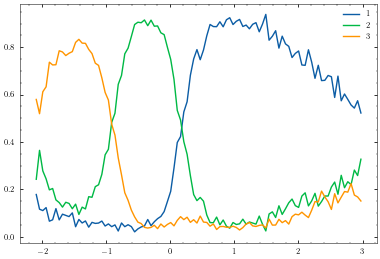

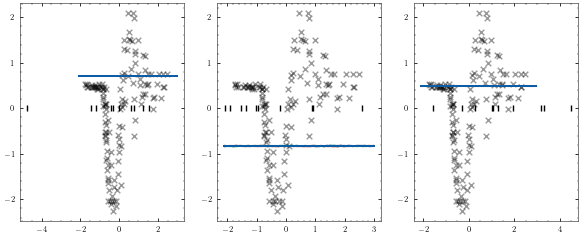

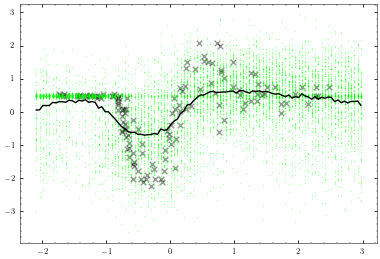

In [36]:
plotter = Plotter1D(model_three_experts, X, Y)
plotter.plot_model()